In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import pandas as pd
# Modelo preentrenado
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
from skimage import measure
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



## Exploración de los datos

In [17]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv(r'../data/test.csv')


base_path=r'notebooks/train_images'

# Se guarda el path de las imagenes dentro del dataframe
train_df['img_path']= f'{base_path}'\
                    + '/' + train_df.patient_id.astype(str)\
                    + '/' + train_df.image_id.astype(str)\
                    + '.png'



display(train_df.head(3))

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_path
0,2,10006,462822612,L,CC,61,0,0,0,NaN,0,NaN,29,False,notebooks/train_images/10006/462822612.png
1,2,10006,1459541791,L,MLO,61,0,0,0,NaN,0,NaN,29,False,notebooks/train_images/10006/1459541791.png
2,2,10006,1864590858,R,MLO,61,0,0,0,NaN,0,NaN,29,False,notebooks/train_images/10006/1864590858.png


In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54706 non-null  int64  
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
 14  img_path              

Existen variables con valores nulos que según la literatura podrían tener gran incidencia en la identificación del cancer en la mama, cómo la clasificación BIRADS y la densidad de la mama.

La clasificación BIRADS:
+ 0: Si la mama requirió seguimiento
+ 1: Si la mama fue calificada como negativo para cancer
+ 2: Si la mama fue calificada como  normal

Density: "Densidad"
Calificación que indica que tan denso es el tejido mamario. 
+ Iniciando en A para los casos en donde la mama es la menos densa y D para los mas densos.

In [34]:
train_df.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,54706.000000,54706.000000,5.470600e+04,54706.000000,54706.000000,54706.000000,54706.000000,26286.000000,54706.000000,54706.000000
mean,1.460407,32698.865262,1.079386e+09,58.538149,0.021168,0.054272,0.014953,0.772350,0.026999,54.618378
std,0.498434,18893.861534,6.183269e+08,10.049939,0.143944,0.226556,0.121365,0.590062,0.162081,44.784800
min,1.000000,5.000000,6.849100e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,1.000000,16481.000000,5.458153e+08,51.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000
50%,1.000000,32432.000000,1.082689e+09,59.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,2.000000,48999.000000,1.613228e+09,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,2.000000,65534.000000,2.147472e+09,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


+ **site_id**: Indica el sitio donde se recolectaron los datos. Hay dos sitios (mínimo 1, máximo 2). La mayoría de los registros provienen del sitio 1, como se deduce por la mediana (50%) y el 25% y 75% iguales a 1.
+ **patient_id**: Identifica a los pacientes. Los valores van desde 5 hasta 65,534, probablemente identificadores únicos. Hay 54,706 pacientes en total.
+ image_id: Representa los identificadores de las imágenes. Los valores son grandes números enteros (probablemente IDs generados). Su rango es amplio, desde 68,491 hasta 2,147,472,000.
+ **age**: Variable binaria que indica si hay diagnóstico de cáncer (1: Sí, 0: No). Promedio: 0.021, lo que implica que el 2.1% de las observaciones tienen un diagnóstico positivo. Máximo: 1 (presencia de cáncer).
+ **biopsy**: Indica si el paciente tuvo una biopsia. Promedio: 0.054, lo que implica que el 5.4% de las observaciones incluyen biopsias realizadas. Máximo: 1 (sí tuvo biopsia).
+ **invasive**: Indica si el cáncer es invasivo. Promedio: 0.015, lo que implica que el 1.5% de las observaciones tienen diagnóstico de cáncer invasivo. Máximo: 1 (presencia de invasión).
+ **BIRADS**: Puntuación BI-RADS para categorizar imágenes de mamografía. Datos disponibles para 26,286 registros. Promedio: 0.77 (lo que puede sugerir una concentración en categorías bajas). Rango: 0 (sin categoría asignada) a 2 (categoría más alta presente en el conjunto).
+ **implant**: Indica si el paciente tiene implantes mamarios. Promedio: 0.027, lo que implica que el 2.7% de las observaciones corresponden a pacientes con implantes. Máximo: 1 (presencia de implantes).
+ **machine_id**: Identifica el equipo o máquina utilizada para la mamografía. Promedio: 54.62. Rango: 21 a 216, lo que sugiere una gran diversidad de máquinas utilizadas.

Puntos claves:

+ La mayoría de los pacientes tienen más de 50 años.
+ Los casos positivos de cáncer (2.1%) y biopsias (5.4%) son relativamente pocos en comparación con el tamaño total del conjunto de datos.
+ Hay datos faltantes en la columna BIRADS, ya que solo tiene 26,286 valores registrados de 54,706 posibles.
+ Se observan características poblacionales y tecnológicas (edad avanzada de los pacientes, gran diversidad de máquinas)

## Preprocesamiento

La clasificación BI-RADS es un componente crucial en el análisis de mamografías, ya que proporciona una evaluación estandarizada del riesgo y orienta las decisiones clínicas.

La ausencia de este dato para pacientes con cáncer podría dificultar el análisis de la severidad o el tipo de lesión detectada.

In [35]:
patients_with_nan_BIRADS = train_df[train_df['BIRADS'].isna()]
patients_with_cancer_nan_BIRADS = patients_with_nan_BIRADS[patients_with_nan_BIRADS['cancer'] == 1]

# Cantidad de pancientes con cancer y clasificación BIRADS nan
print(len(patients_with_cancer_nan_BIRADS))

494


In [36]:
# Analizar la distribución de BI-RADS (asume que es una columna llamada 'BIRADS')
birads = train_df['BIRADS'].dropna()

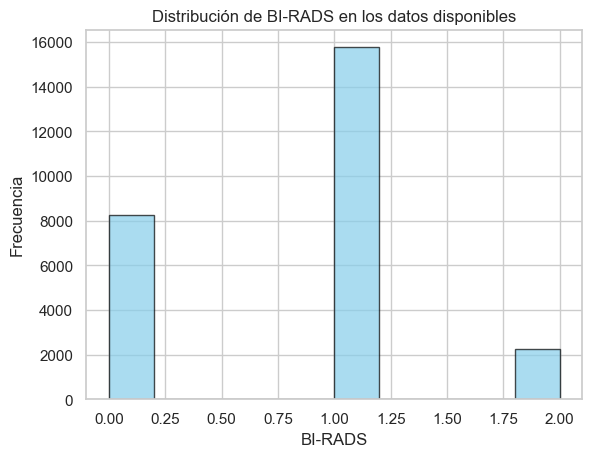

In [37]:
# Analizar la distribución existente
plt.hist(birads, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de BI-RADS en los datos disponibles')
plt.xlabel('BI-RADS')
plt.ylabel('Frecuencia')
plt.show()

**Analisis distribución**
- La categoría 1.0 es la más prevalente, con más de 16,000 registros.
- La categoría 0.0 también tiene una representación considerable, con alrededor de 8,000 registros.
- La categoría 2.0 tiene la menor cantidad de registros, en comparación con las otras dos.

**Simulación de montecarlo básica para valores faltantes**

1. calcular las probabilidades de cada categoría de BI-RADS (0, 1, 2) con base en su frecuencia relativa en los datos disponibles.
2. Usar estas probabilidades para imputar valores faltantes de manera aleatoria, manteniendo las proporciones observadas en los datos originales.

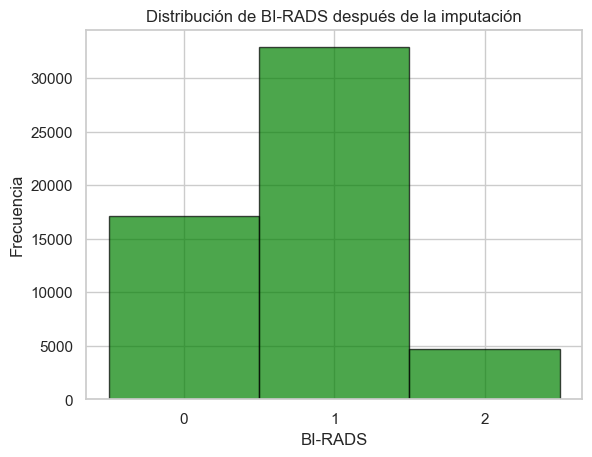

In [38]:
# Calcular las probabilidades dinámicamente
available_birads = train_df['BIRADS'].dropna()  # Valores disponibles
birads_probs = available_birads.value_counts(normalize=True).sort_index().to_list()

# Función para simular valores faltantes
def simulate_categorical_birads(size, probs):
    categories = [0, 1, 2]  # Los valores posibles de BI-RADS
    simulated_values = np.random.choice(categories, size=size, p=probs)
    return simulated_values

np.random.seed(42)  # Para reproducibilidad

# Identificar los índices con valores faltantes
missing_indices = train_df[train_df['BIRADS'].isnull()].index
num_missing = len(missing_indices)

# Simular los valores faltantes usando las probabilidades dinámicas
simulated_birads = simulate_categorical_birads(num_missing, birads_probs)

# Imputar los valores simulados
train_df.loc[missing_indices, 'BIRADS'] = simulated_birads

# Visualizar la distribución después de la imputación
plt.hist(train_df['BIRADS'], bins=[-0.5, 0.5, 1.5, 2.5], color='green', edgecolor='black', alpha=0.7)
plt.xticks([0, 1, 2])
plt.title('Distribución de BI-RADS después de la imputación')
plt.xlabel('BI-RADS')
plt.ylabel('Frecuencia')
plt.show()

**Distribución después de la imputación:**

- La distribución se ajusta a las proporciones originales calculadas antes de la imputación:
- La categoría 1.0 sigue siendo la más prevalente.
- Las categorías 0.0 y 2.0 tienen menor representación, como en los datos originales.

Este método asume que los valores faltantes son completamente aleatorios y que su distribución sigue las probabilidades observadas. 

In [39]:
# Comparar distribuciones
original_distribution = available_birads.value_counts(normalize=True).sort_index()
imputed_distribution = train_df['BIRADS'].value_counts(normalize=True).sort_index()

comparison = pd.DataFrame({
    'Original': original_distribution,
    'Imputed': imputed_distribution
})
print(comparison)

        Original   Imputed
BIRADS                    
0.0     0.313817  0.312690
1.0     0.600015  0.601122
2.0     0.086168  0.086188


Validación de nulos en variable densidad

In [40]:
# Ver valores únicos y frecuencias
print(train_df['density'].value_counts())

density
B    12651
C    12175
A     3105
D     1539
Name: count, dtype: int64


In [41]:
#Cálculo de las probabilidades dinamicamente
# Filtrar los datos disponibles
available_density = train_df['density'].dropna()

# Calcular las frecuencias relativas
density_probs = available_density.value_counts(normalize=True).sort_index().to_list()
print(f"Probabilidades calculadas dinámicamente: {density_probs}")

Probabilidades calculadas dinámicamente: [0.10536138445877163, 0.4292840176450628, 0.41313199864268746, 0.052222599253478115]


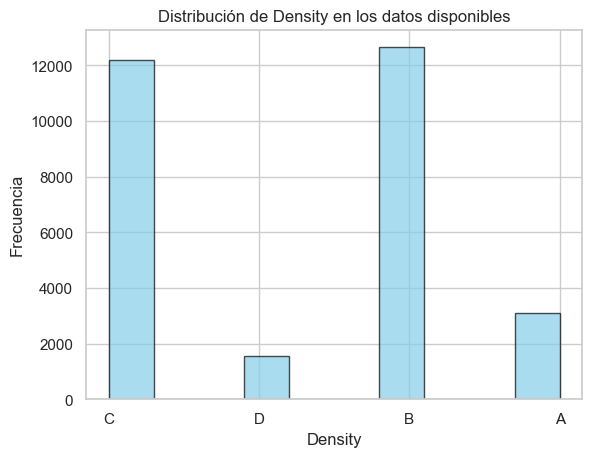

In [42]:
# Analizar la distribución existente
plt.hist(available_density, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de Density en los datos disponibles')
plt.xlabel('Density')
plt.ylabel('Frecuencia')
plt.show()

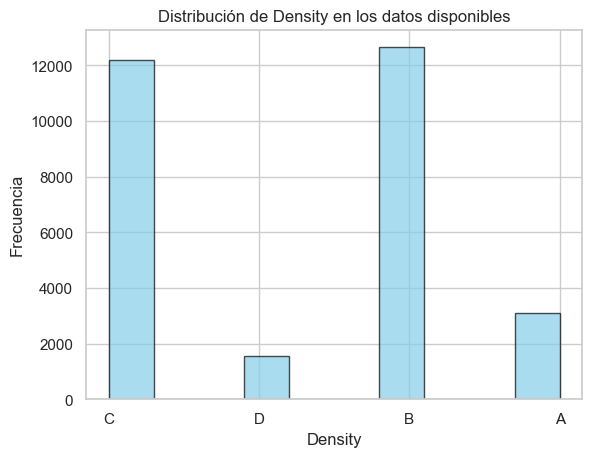

In [43]:
# Analizar la distribución existente
plt.hist(available_density, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de Density en los datos disponibles')
plt.xlabel('Density')
plt.ylabel('Frecuencia')
plt.show()

In [44]:
#Validamos la imputación
# Distribuciones original e imputada
original_density_distribution = available_density.value_counts(normalize=True).sort_index()
imputed_density_distribution = train_df['density'].value_counts(normalize=True).sort_index()

# Crear comparación
density_comparison = pd.DataFrame({
    'Original': original_density_distribution,
    'Imputed': imputed_density_distribution
})
print(density_comparison)

         Original   Imputed
density                    
A        0.105361  0.105361
B        0.429284  0.429284
C        0.413132  0.413132
D        0.052223  0.052223


cancer
0    53548
1     1158
Name: count, dtype: int64


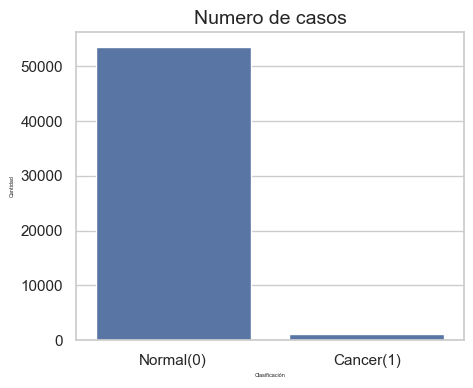

In [45]:
cases_count = train_df['cancer'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,4))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Numero de casos', fontsize=14)
plt.xlabel('Clasificación', fontsize=4)
plt.ylabel('Cantidad', fontsize=4)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Cancer(1)'])
plt.show()

**Visualización del conjunto de imagenes:**

Primera fila imagenes con cancer
Segunda fila imegenes sin cancer

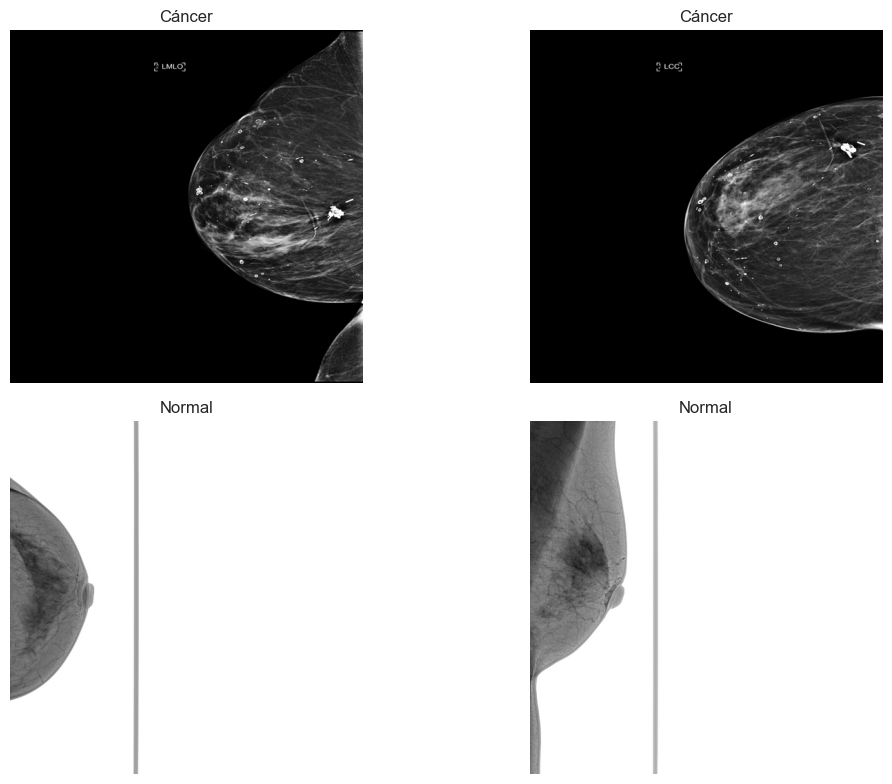

In [46]:
# Visualizar imágenes clasificadas como Cáncer y No Cáncer
Cancer_samples = (train_df[train_df['cancer'] == 1]['img_path'].iloc[0:2]).tolist()
Normal_samples = (train_df[train_df['cancer'] == 0]['img_path'].iloc[0:2]).tolist()

samples = Cancer_samples + Normal_samples

# Mostrar en 2x2
f, ax = plt.subplots(2, 2, figsize=(12, 8))

for i in range(4):
    img = tf.keras.preprocessing.image.load_img(samples[i])
    ax[i // 2, i % 2].imshow(img, cmap='gray')
    
    label = "Cáncer" if i < 2 else "Normal"
    ax[i // 2, i % 2].set_title(label)
    ax[i // 2, i % 2].axis('off')

plt.tight_layout()
plt.show()


Histogramas de pacientes con y sin cancer para visualizar distribución, media, mediana, minimo y maximo por tipo de diagnostico

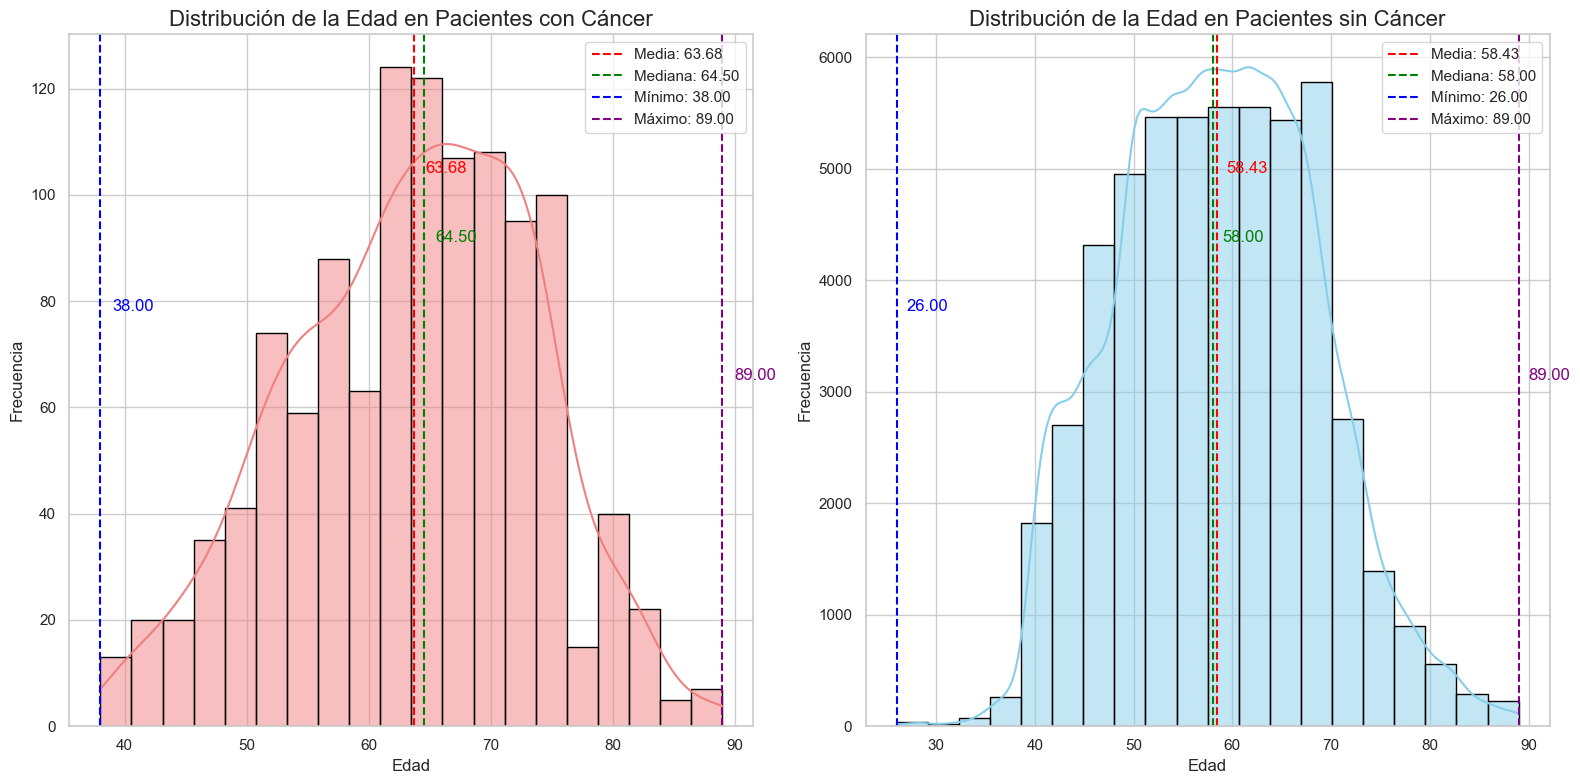

In [47]:
# Separar los datos entre pacientes con cáncer y sin cáncer
cancer_df = train_df[train_df['cancer'] == 1]
no_cancer_df = train_df[train_df['cancer'] == 0]

# Crear una figura con dos gráficos (uno para cáncer, otro para no cáncer)
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# --- Gráfico para pacientes con cáncer ---
sns.histplot(cancer_df['age'], kde=True, bins=20, color='lightcoral', edgecolor='black', ax=axes[0])

# Calcular estadísticos para pacientes con cáncer
mean_age_cancer = cancer_df['age'].mean()
median_age_cancer = cancer_df['age'].median()
min_age_cancer = cancer_df['age'].min()
max_age_cancer = cancer_df['age'].max()

# Añadir líneas de estadísticos
axes[0].axvline(mean_age_cancer, color='red', linestyle='--', label=f'Media: {mean_age_cancer:.2f}')
axes[0].axvline(median_age_cancer, color='green', linestyle='--', label=f'Mediana: {median_age_cancer:.2f}')
axes[0].axvline(min_age_cancer, color='blue', linestyle='--', label=f'Mínimo: {min_age_cancer:.2f}')
axes[0].axvline(max_age_cancer, color='purple', linestyle='--', label=f'Máximo: {max_age_cancer:.2f}')
# Añadir anotaciones
axes[0].text(mean_age_cancer + 1, axes[0].get_ylim()[1] * 0.8, f'{mean_age_cancer:.2f}', color='red')
axes[0].text(median_age_cancer + 1, axes[0].get_ylim()[1] * 0.7, f'{median_age_cancer:.2f}', color='green')
axes[0].text(min_age_cancer + 1, axes[0].get_ylim()[1] * 0.6, f'{min_age_cancer:.2f}', color='blue')
axes[0].text(max_age_cancer + 1, axes[0].get_ylim()[1] * 0.5, f'{max_age_cancer:.2f}', color='purple')

# Título y etiquetas para pacientes con cáncer
axes[0].set_title('Distribución de la Edad en Pacientes con Cáncer', fontsize=16)
axes[0].set_xlabel('Edad', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].legend()

# --- Gráfico para pacientes sin cáncer ---
sns.histplot(no_cancer_df['age'], kde=True, bins=20, color='skyblue', edgecolor='black', ax=axes[1])

# Calcular estadísticos para pacientes sin cáncer
mean_age_no_cancer = no_cancer_df['age'].mean()
median_age_no_cancer = no_cancer_df['age'].median()
min_age_no_cancer = no_cancer_df['age'].min()
max_age_no_cancer = no_cancer_df['age'].max()
# Añadir líneas de estadísticos
axes[1].axvline(mean_age_no_cancer, color='red', linestyle='--', label=f'Media: {mean_age_no_cancer:.2f}')
axes[1].axvline(median_age_no_cancer, color='green', linestyle='--', label=f'Mediana: {median_age_no_cancer:.2f}')
axes[1].axvline(min_age_no_cancer, color='blue', linestyle='--', label=f'Mínimo: {min_age_no_cancer:.2f}')
axes[1].axvline(max_age_no_cancer, color='purple', linestyle='--', label=f'Máximo: {max_age_no_cancer:.2f}')

# Añadir anotaciones
axes[1].text(mean_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.8, f'{mean_age_no_cancer:.2f}', color='red')
axes[1].text(median_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.7, f'{median_age_no_cancer:.2f}', color='green')
axes[1].text(min_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.6, f'{min_age_no_cancer:.2f}', color='blue')
axes[1].text(max_age_no_cancer + 1, axes[1].get_ylim()[1] * 0.5, f'{max_age_no_cancer:.2f}', color='purple')

# Título y etiquetas para pacientes sin cáncer
axes[1].set_title('Distribución de la Edad en Pacientes sin Cáncer', fontsize=16)
axes[1].set_xlabel('Edad', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].legend()
# Mostrar el gráfico
plt.tight_layout()
plt.show()

**Matriz de correlación**

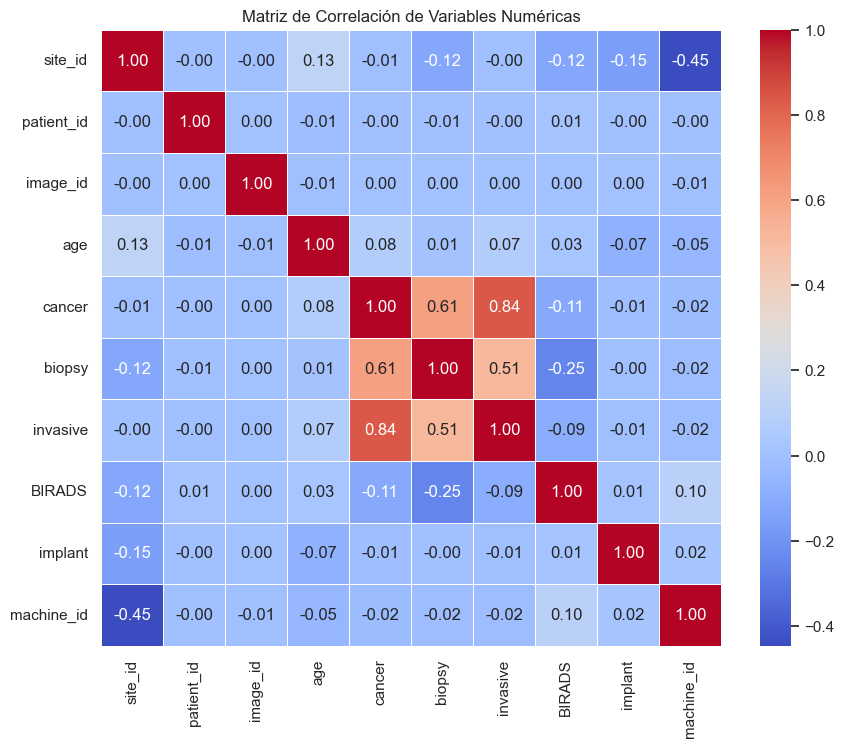

In [48]:
# Seleccionar solo las columnas numéricas del DataFrame
numeric_df = train_df.select_dtypes(include=['float64', 'int64'])

# Calcular la matriz de correlación
corr_matrix = numeric_df.corr()

# Crear el gráfico de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()

* Las correlaciones fuertes entre cancer, invasive, y biopsy confirman su estrecha relación clínica. Esto implica que estas variables están alineadas con el flujo normal del diagnóstico y tratamiento del cáncer.

* La correlación negativa moderada entre BI-RADS y biopsy destaca el valor de BI-RADS como un predictor inicial para decidir pruebas adicionales.

* La relación entre site_id y machine_id sugiere diferencias entre los sitios en términos de tecnología o metodología, que podrían introducir sesgos en los datos. 

C:\Users\Melissa\AppData\Local\Temp\ipykernel_57704\3099771393.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cancer', y='age', data=train_df, palette=['blue', 'red'])


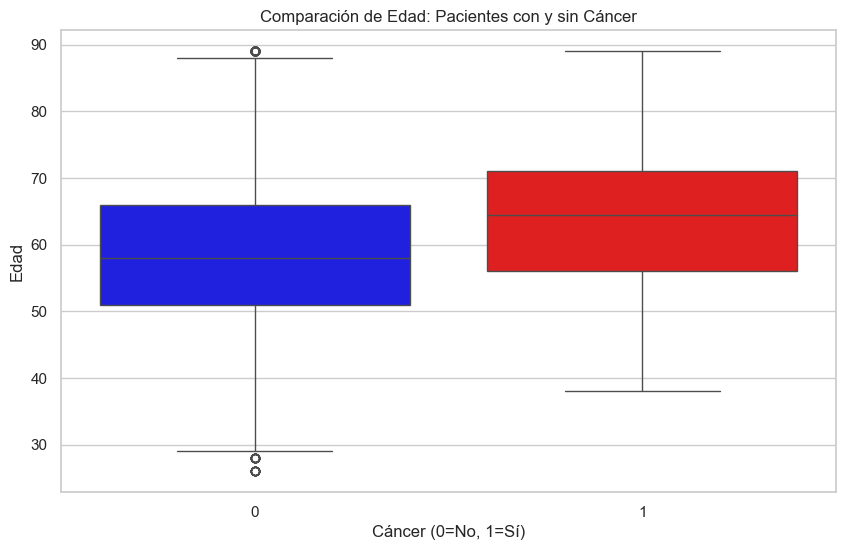

In [49]:
# Filtrar los pacientes con cáncer y sin cáncer
cancer_patients = train_df[train_df['cancer'] == 1]
no_cancer_patients = train_df[train_df['cancer'] == 0]

# Configurar estilo visual
sns.set(style="whitegrid")

# Boxplot para comparar las distribuciones de edad
plt.figure(figsize=(10, 6))
sns.boxplot(x='cancer', y='age', data=train_df, palette=['blue', 'red'])
plt.title('Comparación de Edad: Pacientes con y sin Cáncer')
plt.xlabel('Cáncer (0=No, 1=Sí)')
plt.ylabel('Edad')
plt.show()

**Pacientes sin cáncer (Cáncer = 0, barra azul):**

* Rango intercuartílico (IQR): La mayoría de los pacientes tienen edades entre aproximadamente 52 y 65 años.
* Mediana: Alrededor de los 58 años.
* Rango completo: Los pacientes sin cáncer tienen edades que van desde los 30 hasta los 89 años, con algunos outliers menores por debajo de los 40 años.

**Pacientes con cáncer (Cáncer = 1, barra roja):**

* Rango intercuartílico (IQR): La mayoría de los pacientes tienen edades entre aproximadamente 60 y 70 años.
* Mediana: Alrededor de los 65 años, notablemente mayor que para los pacientes sin cáncer.
* Rango completo: Los pacientes con cáncer también tienen edades entre 30 y 89 años, pero con un rango ligeramente desplazado hacia valores más altos.

* Existe una clara diferencia en la distribución de edad entre los dos grupos, con los pacientes con cáncer tendiendo a ser mayores.
* Esto es consistente con el conocimiento médico: el riesgo de cáncer generalmente aumenta con la edad debido a factores acumulativos como mutaciones celulares y cambios hormonales.
* La variable age puede ser un predictor útil para modelos de clasificación, ya que muestra diferencias notables entre los dos grupos.

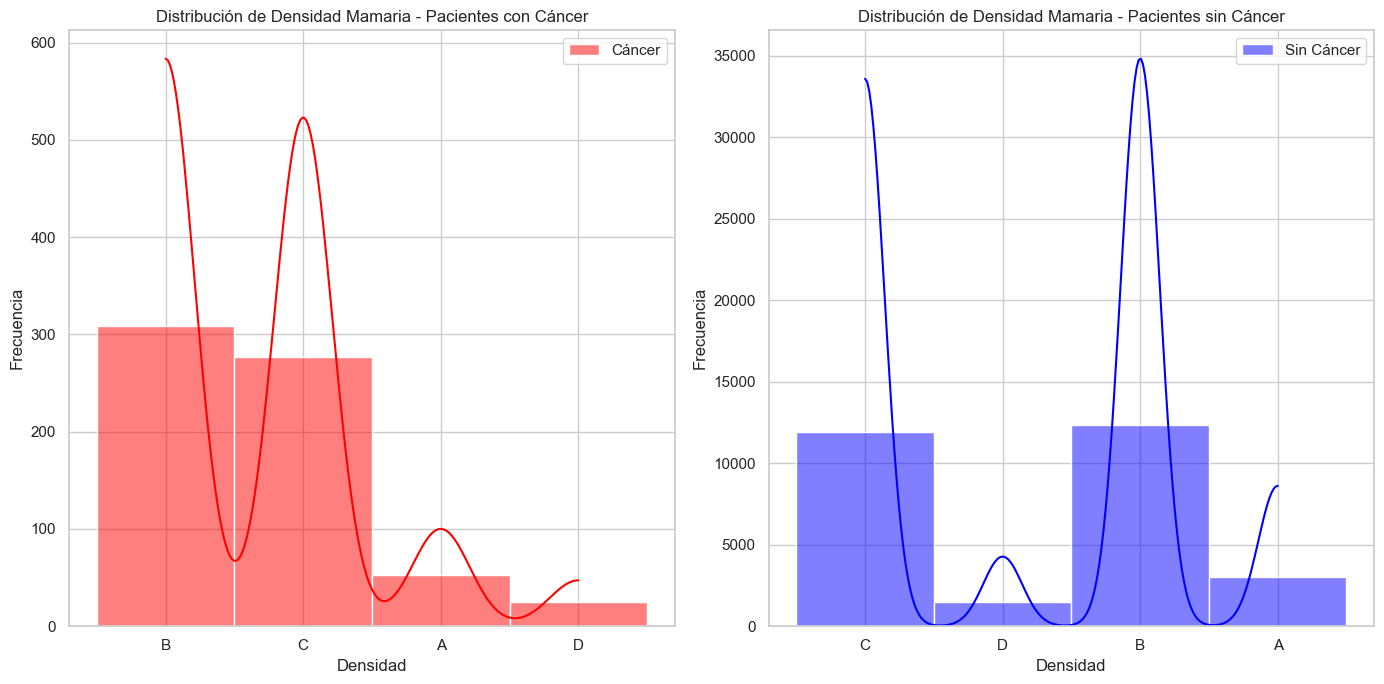

In [50]:
# Histograma para visualizar la distribución de la densidad
plt.figure(figsize=(14, 7))

# Densidad en pacientes con cáncer
plt.subplot(1, 2, 1)
sns.histplot(cancer_patients['density'], kde=True, bins=20, color='red', label='Cáncer')
plt.title('Distribución de Densidad Mamaria - Pacientes con Cáncer')
plt.xlabel('Densidad')
plt.ylabel('Frecuencia')
plt.legend()

# Densidad en pacientes sin cáncer
plt.subplot(1, 2, 2)
sns.histplot(no_cancer_patients['density'], kde=True, bins=20, color='blue', label='Sin Cáncer')
plt.title('Distribución de Densidad Mamaria - Pacientes sin Cáncer')
plt.xlabel('Densidad')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

**Pacientes con cáncer (gráfico izquierdo, color rojo):**

+ Densidad B: Es la más prevalente en este grupo, con una frecuencia alta.
+ Densidad C: También es común, aunque en menor proporción que la densidad B.
+ Densidades A y D: Tienen una representación mucho menor, siendo la densidad D la menos común.

**Pacientes sin cáncer (gráfico derecho, color azul):**

+ Densidad B y C: Ambas tienen una representación notable, pero la densidad C es más prevalente en este grupo, a diferencia de los pacientes con cáncer.
+ Densidades A y D: Siguen siendo menos frecuentes, pero la densidad A es ligeramente más común aquí que en los pacientes con cáncer.

Densidad B:
- Más prevalente entre pacientes con cáncer, lo que podría sugerir una relación entre esta densidad y el diagnóstico de cáncer.

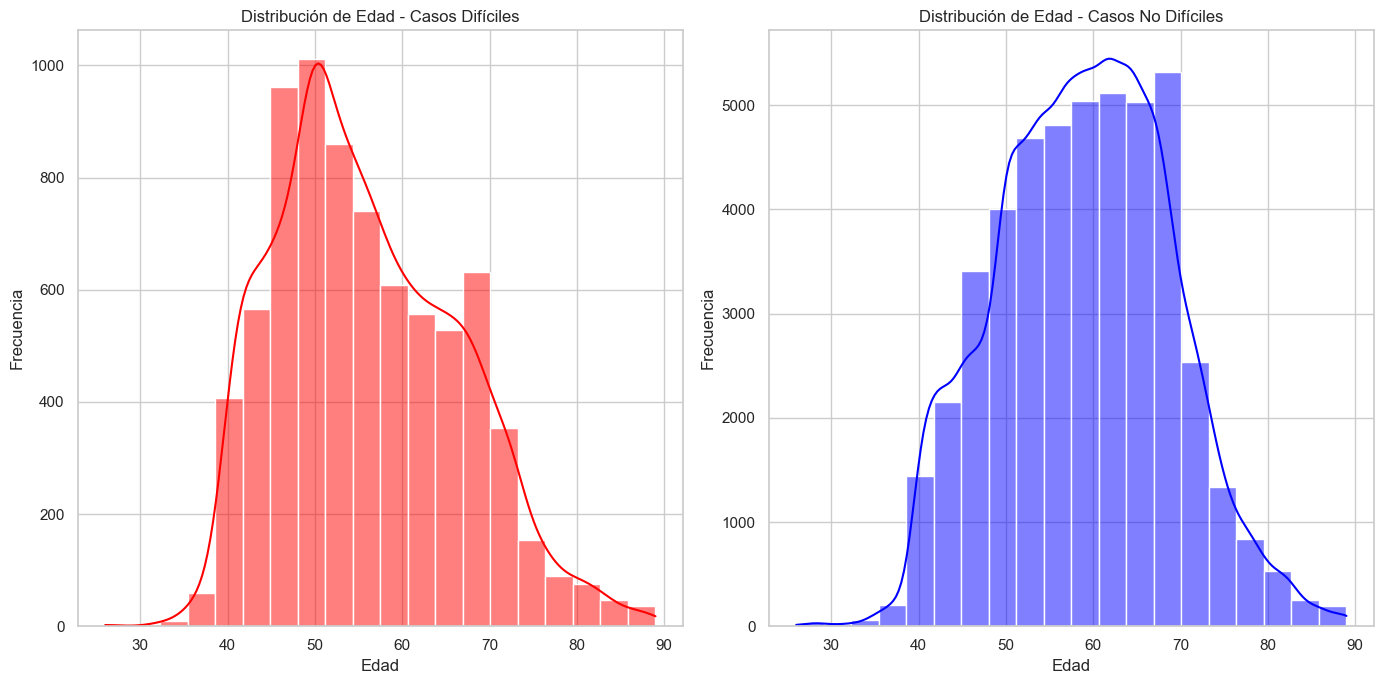

C:\Users\Melissa\AppData\Local\Temp\ipykernel_57704\825165943.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=difficult_cases, x='view', palette='Reds')
C:\Users\Melissa\AppData\Local\Temp\ipykernel_57704\825165943.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=non_difficult_cases, x='view', palette='Blues')


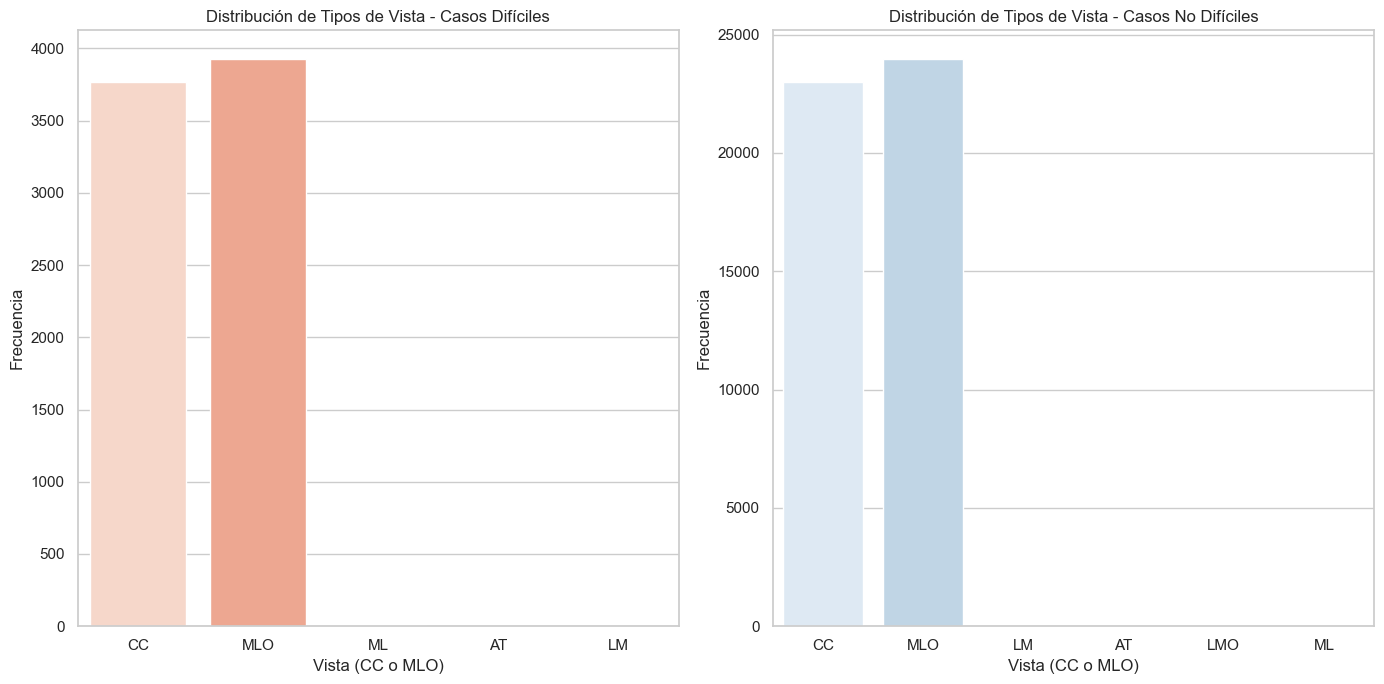

In [51]:
# Filtrar casos difíciles y no difíciles
difficult_cases = train_df[train_df['difficult_negative_case'] == True]
non_difficult_cases = train_df[train_df['difficult_negative_case'] == False]

# Configurar estilo visual
sns.set(style="whitegrid")

# Comparar la edad en casos difíciles y no difíciles
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.histplot(difficult_cases['age'], kde=True, bins=20, color='red', label='Difícil')
plt.title('Distribución de Edad - Casos Difíciles')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.histplot(non_difficult_cases['age'], kde=True, bins=20, color='blue', label='No Difícil')
plt.title('Distribución de Edad - Casos No Difíciles')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

# Comparar el tipo de vista en casos difíciles y no difíciles
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(data=difficult_cases, x='view', palette='Reds')
plt.title('Distribución de Tipos de Vista - Casos Difíciles')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.countplot(data=non_difficult_cases, x='view', palette='Blues')
plt.title('Distribución de Tipos de Vista - Casos No Difíciles')
plt.xlabel('Vista (CC o MLO)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

**Casos difíciles (gráfico izquierdo):**

- Distribución:
    - Tiene un pico (moda) alrededor de los 50 años.
    - Hay una concentración considerable entre los 45 y 55 años, con un declive gradual hacia edades mayores y menores.
- Rango de edad:
    - La mayoría de los casos se encuentran entre 40 y 70 años.
    - Los casos difíciles son menos comunes en edades menores a 40 y mayores a 75 años.

**Casos no difíciles(gráfico derecho):**

- Distribución:
    - Tiene un pico (moda) alrededor de los 65 años, mostrando un desplazamiento hacia edades mayores en comparación con los casos difíciles.
    - Hay una distribución más amplia en el rango de edad entre 50 y 70 años, lo que sugiere que los casos no difíciles abarcan una población más diversa en términos de edad.
- Rango de edad:
    - La mayoría de los casos se concentran entre los 50 y 75 años, con una representación más notable en edades mayores (70+).

**Casos difíciles (izquierda, color rojo):**

- Proyecciones CC (Cranio-Caudal):
    - Frecuencia ligeramente menor que MLO.
    - Representa alrededor del 48% de las vistas en los casos difíciles.
- Proyecciones MLO (Medio-Lateral Oblicua):
    - Es la más común entre los casos difíciles, con una ligera ventaja sobre CC.
    - Representa aproximadamente el 52% de las vistas.
- Otras vistas (ML, AT, LM, LMO):
    - No tienen representación en los casos difíciles, lo que implica que estas vistas no se utilizan o no están presentes en este conjunto para estos casos.

**Casos no difíciles (derecha, color azul):**

- Proyecciones CC:
    - Similar a los casos difíciles, CC representa una proporción significativa pero ligeramente menor que MLO.
- Proyecciones MLO:
    - Es la vista más frecuente, representando un porcentaje mayor en comparación con CC.
- Otras vistas (ML, AT, LM, LMO):
    - Estas vistas tampoco están presentes en los casos no difíciles.

- La mayoría de las mamografías en este conjunto de datos utilizan vistas estándar (CC y MLO). Esto es consistente con la práctica clínica, donde estas vistas son las más comunes para evaluar el tejido mamario.
- La vista MLO es la más frecuente en ambos grupos (casos difíciles y no difíciles). Esto podría deberse a que proporciona una mejor visualización de la parte superior y lateral del tejido mamario, lo cual es importante tanto para evaluaciones rutinarias como para casos complejos.
- La distribución entre CC y MLO es muy similar para ambos grupos, lo que indica que la dificultad del caso no parece estar relacionada con el tipo de vista utilizada.

## Reducción del conjunto de datos y balanceo de clases

In [52]:
minority_class_size = train_df['cancer'].value_counts().min()

# Definir la proporción de muestras de la clase mayoritaria (ejemplo: 2 veces la clase minoritaria)
majority_class_multiplier = 10
majority_class_size = minority_class_size * majority_class_multiplier

# Obtener todas las muestras de la clase minoritaria
minority_samples = train_df[train_df['cancer'] == 1]

# Obtener una muestra aleatoria de la clase mayoritaria
majority_samples = train_df[train_df['cancer'] == 0].sample(majority_class_size, random_state=42)

# Combinar las muestras de ambas clases
balanced_df = pd.concat([minority_samples, majority_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

# Verificar el balance de clases
print(balanced_df['cancer'].value_counts())

cancer
0    11580
1     1158
Name: count, dtype: int64


El conjunto de datos inicial era muy grande, lo que podía generar problemas de rendimiento en el entrenamiento del modelo (como mayor tiempo de procesamiento o uso excesivo de recursos). Además, la variable objetivo (cancer) estaba desbalanceada, con una cantidad mucho mayor de muestras de la clase 0 (sin cáncer) frente a la clase 1 (con cáncer). Para solucionar esto:

1. Se calcula el tamaño de la clase minoritaria (minority_class_size) para establecer un punto de referencia.
2. Se incluye 10 veces más muestras de la clase mayoritaria (cancer = 0) que de la clase minoritaria (cancer = 1), ajustando el tamaño total del conjunto.
3. Se extraen todas las muestras de la clase minoritaria (minority_samples).
4. Se toma una muestra aleatoria de la clase mayoritaria (majority_samples) de tamaño proporcional a la clase minoritaria, utilizando un generador de números aleatorios para garantizar reproducibilidad (random_state=42).
5. Se unen las muestras seleccionadas de ambas clases para crear un nuevo conjunto de datos balanceado y reducido.
6. Se reordenan las muestras aleatoriamente para evitar patrones específicos en el orden de las filas.

## Histograma de Color por Clase

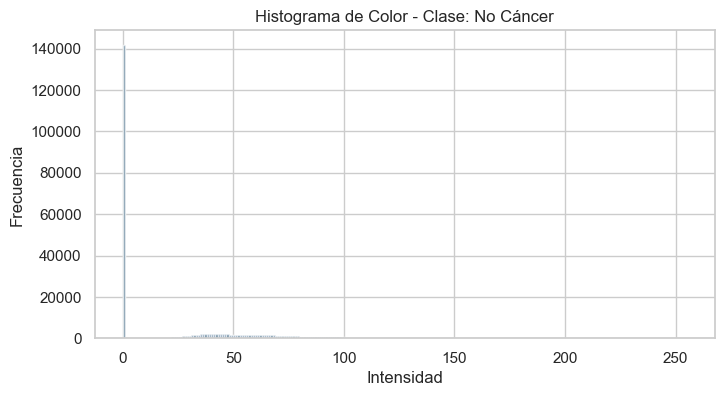

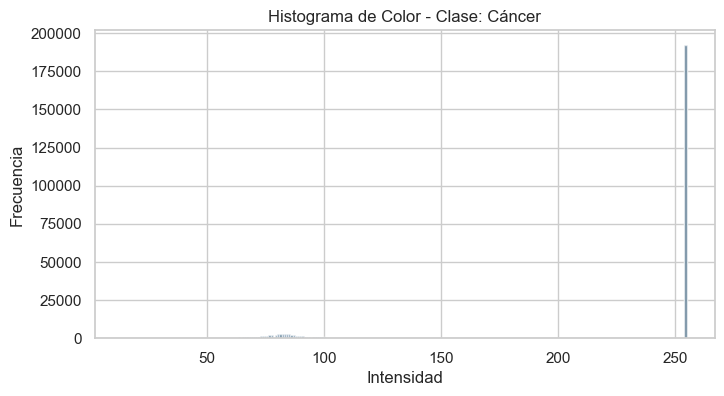

In [53]:
def plot_color_histogram_per_class(df, img_col='img_path', label_col='cancer_str'):
    for label in df[label_col].unique():
        subset = df[df[label_col] == label]
        img = cv2.imread(subset.iloc[0][img_col])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        chans = cv2.split(img)
        colors = ("r", "g", "b")
        plt.figure(figsize=(8, 4))
        plt.title(f"Histograma de Color - Clase: {label}")
        for chan, color in zip(chans, colors):
            plt.hist(chan.ravel(), bins=256, color=color, alpha=0.5)
        plt.xlabel("Intensidad")
        plt.ylabel("Frecuencia")
        plt.show()

balanced_df['cancer_str'] = balanced_df['cancer'].map({0: 'No Cáncer', 1: 'Cáncer'})
plot_color_histogram_per_class(balanced_df)


**Histograma de Intensidades - Clase: No Cáncer**
Pico muy pronunciado cerca de 0:
* Las imágenes de mamografías sin cáncer tienen la mayoría de sus píxeles en valores muy oscuros, es decir, casi negros.
* Esto sugiere ausencia de estructuras densas (como masas o calcificaciones), y predominio de tejido mamario homogéneo o áreas de fondo.
* Pocos valores en intensidades medias o altas:
    * La curva cae rápidamente después del pico inicial, lo que indica que hay muy pocas zonas brillantes en las imágenes.

Por lo que se puede concluir que: Las imágenes sin cáncer son en su mayoría oscuras, con un histograma sesgado fuertemente hacia la izquierda (intensidades bajas), lo que refleja una baja densidad radiológica y ausencia de lesiones relevantes.

**Histograma de Intensidades - Clase: Cáncer**
* Pico fuerte en intensidades altas (~255):
* Las imágenes con cáncer muestran un pico en el extremo derecho del histograma, indicando la presencia de áreas muy brillantes.
* Estas zonas suelen corresponder a calcificaciones, masas densas o bordes anómalos que reflejan más radiación y aparecen más blancas.
* Distribución asimétrica inversa a la clase No Cáncer:
    * La imagen tiene muchas regiones brillantes (intensidad alta) y mucho menos contenido oscuro.

Por lo que las imágenes con cáncer están dominadas por zonas brillantes, lo que indica mayor densidad radiológica asociada a lesiones sospechosas. El histograma está sesgado hacia intensidades altas, a diferencia de la clase No Cáncer.

## Imagenes por clase

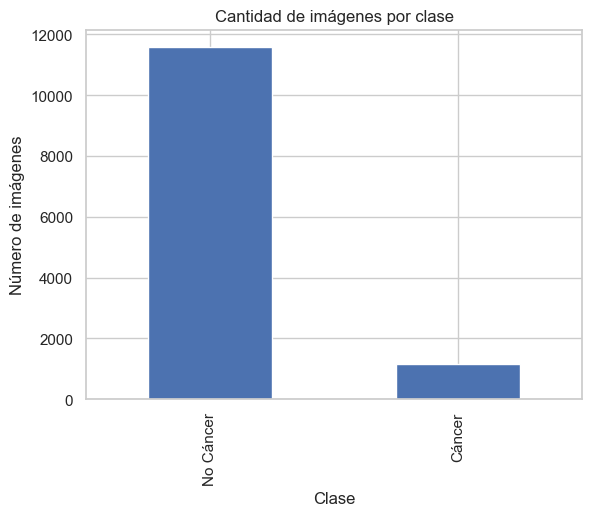

In [54]:
balanced_df['cancer_str'].value_counts().plot(kind='bar', title="Cantidad de imágenes por clase")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.show()

## Histograma de color de objetos segmentados

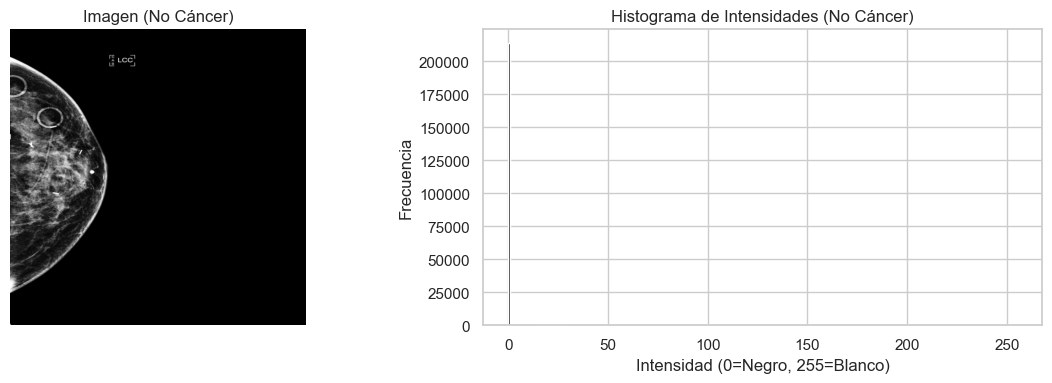

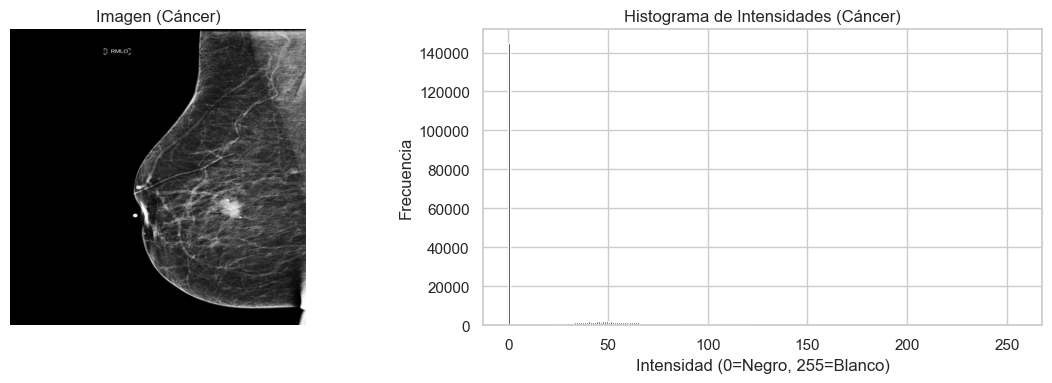

In [55]:
def plot_single_image_histograms(df, img_col='img_path', label_col='cancer_str'):
    classes = df[label_col].unique()
    
    for clase in classes:
        path = df[df[label_col] == clase].sample(1, random_state=2)[img_col].values[0]
        img = cv2.imread(path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        plt.figure(figsize=(12, 4))

        # Imagen original
        plt.subplot(1, 2, 1)
        plt.imshow(img_gray, cmap='gray')
        plt.title(f"Imagen ({clase})")
        plt.axis("off")

        # Histograma
        plt.subplot(1, 2, 2)
        plt.hist(img_gray.ravel(), bins=256, color='black')
        plt.title(f"Histograma de Intensidades ({clase})")
        plt.xlabel("Intensidad (0=Negro, 255=Blanco)")
        plt.ylabel("Frecuencia")

        plt.tight_layout()
        plt.show()

plot_single_image_histograms(balanced_df)



**Interpretación del histograma de intensidades por clase**

**Imagen: No Cáncer**

**Observación visual:**
- La imagen muestra una mamografía con predominio de fondo negro y tejido mamario con baja densidad.
- Se observan algunas marcas circulares típicas, pero no hay presencia de masas o zonas muy brillantes.

**Histograma:**
- El histograma tiene un pico muy pronunciado en intensidades cercanas a 0, lo cual indica que la mayor parte de la imagen corresponde a zonas oscuras (fondo).
- Existe muy poca frecuencia en intensidades medias o altas, lo cual sugiere que el tejido mamario es homogéneo y no contiene estructuras densas.

**Conclusión:**
- Las mamografías sin cáncer suelen estar dominadas por intensidades bajas, asociadas a la ausencia de lesiones. Esta distribución es esperable en imágenes de tejido sano.

---

**Imagen: Cáncer**

**Observación visual:**
- Se observa una lesión densa y brillante en el centro de la mama, destacándose claramente del tejido circundante.
- El contraste general en la imagen es mayor comparado con la imagen sin cáncer.

**Histograma:**
- Aunque también existe un pico en intensidades bajas, se observa una mayor dispersión hacia valores altos (cercanos a 255).
- Esto indica que hay presencia significativa de píxeles brillantes, correspondientes a la región tumoral visible en la imagen.

**Conclusión:**
- Las mamografías con cáncer presentan mayor cantidad de intensidades altas, lo cual refleja la presencia de anomalías densas como masas o calcificaciones.

##  Distribución de tamaños de imagen


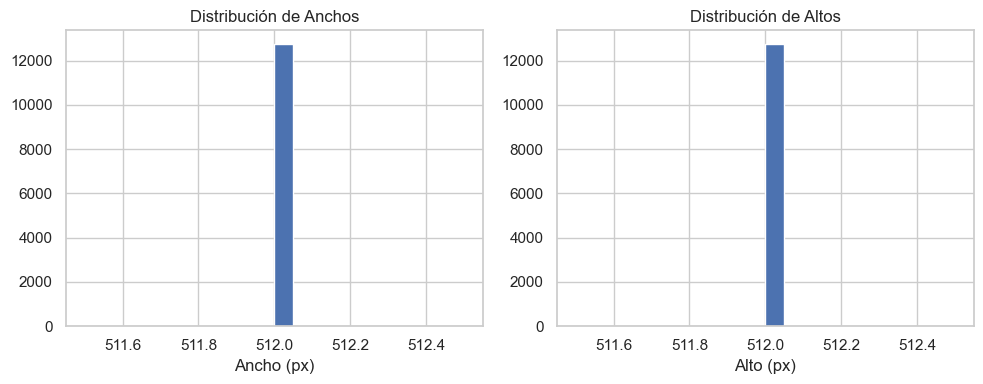

In [56]:
def image_size_distribution(df, img_col='img_path'):
    sizes = df[img_col].apply(lambda p: Image.open(p).size)  # (ancho, alto)
    widths, heights = zip(*sizes)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20)
    plt.title("Distribución de Anchos")
    plt.xlabel("Ancho (px)")
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20)
    plt.title("Distribución de Altos")
    plt.xlabel("Alto (px)")
    plt.tight_layout()
    plt.show()

image_size_distribution(balanced_df)


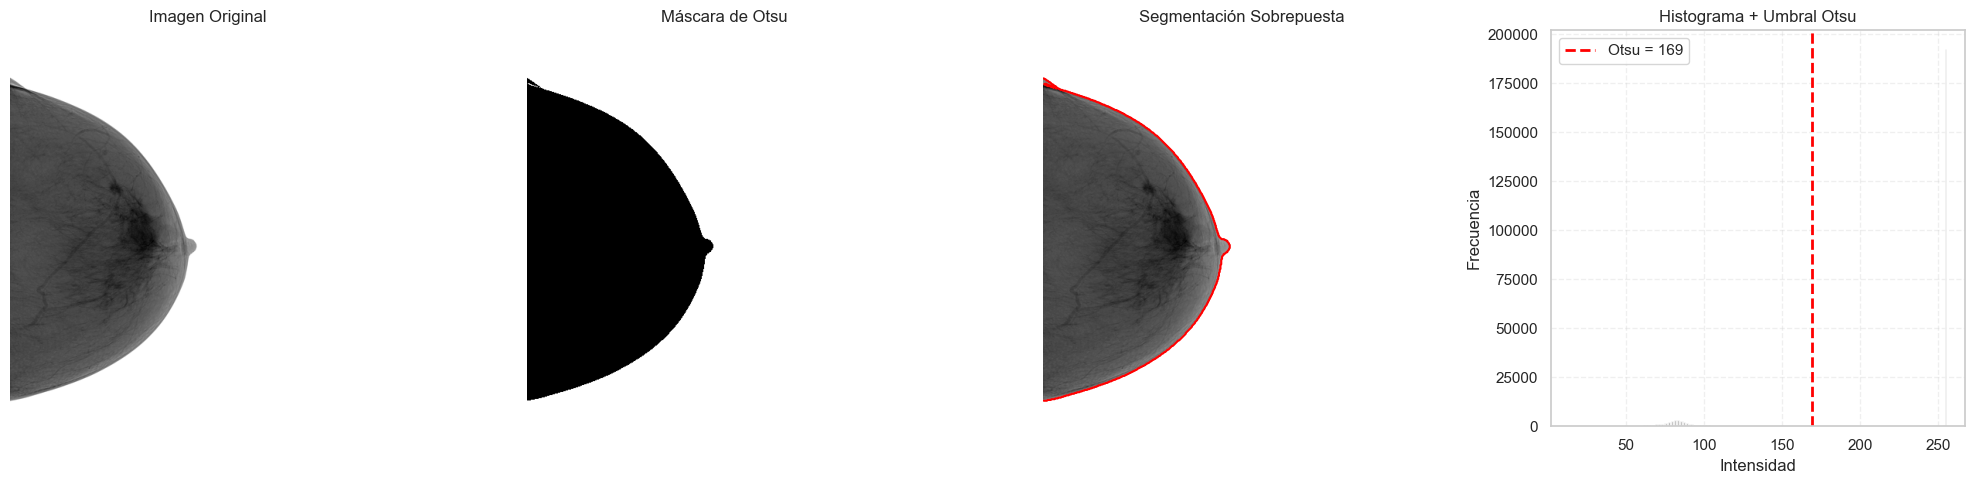

In [57]:
def analisis_completo_con_otsu(path):
    # Leer imagen en escala de grises
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Calcular umbral de Otsu
    otsu_thresh = threshold_otsu(img)

    # Generar máscara
    mask = img > otsu_thresh

    # Contornos de la máscara
    contours = measure.find_contours(mask, 0.5)

    # Crear figura con 4 subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # Imagen original
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Imagen Original')
    axs[0].axis('off')

    # Máscara binaria
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Máscara de Otsu')
    axs[1].axis('off')

    # Segmentación sobrepuesta
    axs[2].imshow(img, cmap='gray')
    for contour in contours:
        axs[2].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='red')
    axs[2].set_title('Segmentación Sobrepuesta')
    axs[2].axis('off')

    # Histograma con línea de Otsu
    axs[3].hist(img.ravel(), bins=256, color='gray', alpha=0.7)
    axs[3].axvline(otsu_thresh, color='red', linestyle='--', linewidth=2, label=f'Otsu = {otsu_thresh:.0f}')
    axs[3].set_title('Histograma + Umbral Otsu')
    axs[3].set_xlabel('Intensidad')
    axs[3].set_ylabel('Frecuencia')
    axs[3].legend()
    axs[3].grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Imagen con cancer
img_path = balanced_df[balanced_df['cancer'] == 1].iloc[0]['img_path']
analisis_completo_con_otsu(img_path)



**Segmentación de imagen con cáncer usando el método de Otsu**

Se presenta una imagen mamográfica correspondiente a un caso con diagnóstico de cáncer. La imagen fue analizada mediante el umbral automático de Otsu para segmentar el área de interés (tejido mamario).

**Panel 1: Imagen original**
La imagen muestra una mamografía en escala de grises con estructuras glandulares visibles. Se observa una zona más densa en el centro, la cual podría corresponder a una masa tumoral. El contraste general de la imagen es alto.

**Panel 2: Máscara de Otsu**
Aplicando el método de Otsu se obtiene una máscara binaria que separa el tejido mamario (blanco) del fondo (negro). El algoritmo seleccionó automáticamente un umbral de intensidad de **169**, valor relativamente alto, lo cual sugiere la presencia de regiones brillantes en la imagen.

**Panel 3: Segmentación sobrepuesta**
La segmentación obtenida se superpone a la imagen original con un contorno rojo. Se observa que la máscara delimita correctamente el contorno de la mama, capturando gran parte del tejido relevante.

**Panel 4: Histograma de intensidades**
El histograma muestra la distribución de intensidades en la imagen. El umbral de Otsu (169) está indicado por una línea punteada roja. La mayoría de los píxeles están concentrados por debajo de este umbral, mientras que las intensidades superiores (asociadas a lesiones) ocupan una fracción menor, pero significativa.

**Conclusión:**
El valor alto del umbral de Otsu y la forma de la segmentación son coherentes con la presencia de un área densa en la imagen. Este análisis respalda la utilidad del umbral Otsu y del área segmentada como variables explicativas para modelos de predicción del cáncer de mama.


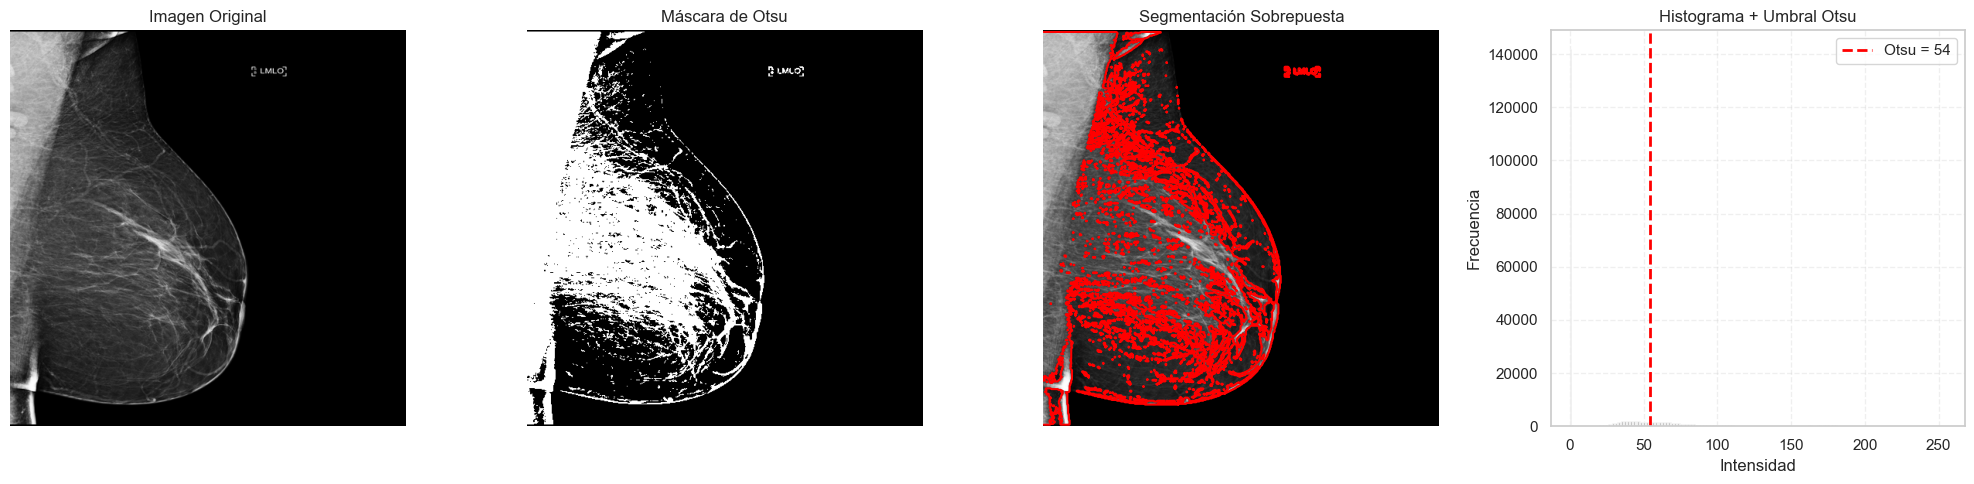

In [58]:
img_path = balanced_df[balanced_df['cancer'] == 0].iloc[0]['img_path'] # imagen sin cancer
analisis_completo_con_otsu(img_path)

Se presenta una mamografía correspondiente a un caso **sin diagnóstico de cáncer**. Se aplica el método de Otsu para segmentar el tejido mamario, con el objetivo de observar diferencias estructurales frente a los casos con cáncer.

**Panel 1: Imagen original**
La imagen muestra una mamografía en escala de grises con distribución homogénea del tejido. No se observan regiones particularmente brillantes ni formaciones nodulares destacadas.

**Panel 2: Máscara de Otsu**
La máscara generada por el algoritmo de Otsu presenta una segmentación más dispersa, con muchas pequeñas regiones brillantes dentro del tejido mamario. El umbral calculado fue de **54**, significativamente menor que en los casos con cáncer. Esto sugiere que la mayoría de los píxeles relevantes se encuentran en zonas menos brillantes (intensidades bajas).

**Panel 3: Segmentación sobrepuesta**
El contorno generado por la máscara se superpone en rojo sobre la imagen original. La segmentación cubre estructuras internas sin destacar áreas densas centrales, como en los casos con cáncer. La segmentación es más difusa y refleja la falta de masas hiperintensas.

**Panel 4: Histograma de intensidades**
El histograma muestra una fuerte concentración de intensidades en valores bajos (cercanos a 0), lo que coincide con el umbral bajo de Otsu. Esto es consistente con una imagen donde predominan los tejidos blandos sin anomalías densas.

**Conclusión:**
El umbral bajo y la segmentación dispersa obtenida con Otsu son indicativos de una mamografía sin áreas sospechosas. Estos resultados refuerzan el valor del umbral de Otsu y la forma de la segmentación como posibles descriptores para distinguir imágenes normales de aquellas con signos de cáncer.


In [59]:
# Crear lista de resultados
otsu_data = []

# Iterar sobre todas las imágenes
for _, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
    img_path = row['img_path']
    label = row['cancer_str']  # 'Cáncer' o 'No Cáncer'

    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            thresh = threshold_otsu(img)
            otsu_data.append({'img_path': img_path, 'cancer_str': label, 'otsu_threshold': thresh})
    except Exception as e:
        print(f"⚠️ Error con {img_path}: {e}")

# Convertir a DataFrame
otsu_df = pd.DataFrame(otsu_data)


100%|██████████| 12738/12738 [00:50<00:00, 252.90it/s]


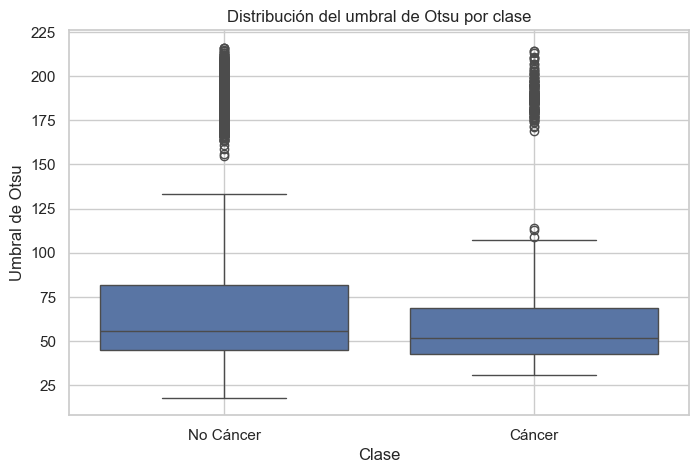

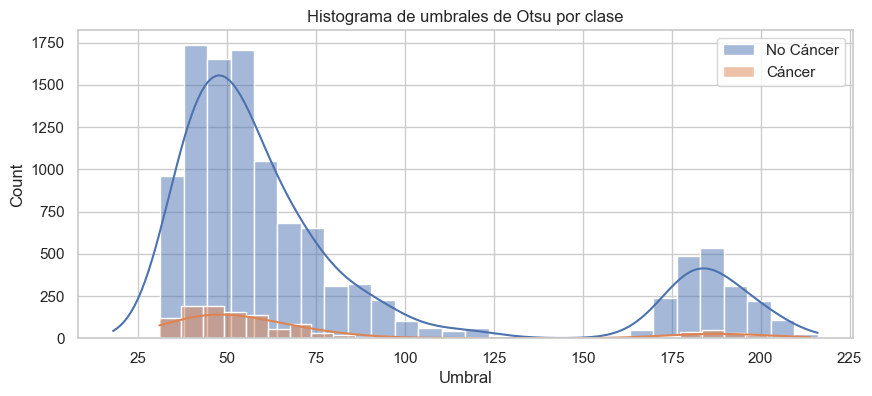

In [60]:
# Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(data=otsu_df, x='cancer_str', y='otsu_threshold')
plt.title('Distribución del umbral de Otsu por clase')
plt.ylabel('Umbral de Otsu')
plt.xlabel('Clase')
plt.grid(True)
plt.show()

# Histograma
plt.figure(figsize=(10, 4))
for clase in otsu_df['cancer_str'].unique():
    sns.histplot(otsu_df[otsu_df['cancer_str'] == clase]['otsu_threshold'], label=clase, kde=True, bins=30)
plt.title('Histograma de umbrales de Otsu por clase')
plt.xlabel('Umbral')
plt.legend()
plt.show()


**Análisis de distribución del umbral de Otsu por clase**

Para cada mamografía del dataset, se calculó el umbral de Otsu de forma individual con el objetivo de explorar su comportamiento como posible descriptor diagnóstico.

**Gráfico 1: Diagrama de caja (Boxplot)**
El diagrama de caja muestra la distribución del valor de umbral de Otsu en dos grupos: **No Cáncer** y **Cáncer**.

- El grupo **No Cáncer** presenta una mayor dispersión, con presencia de valores extremos (outliers) elevados.
- El grupo **Cáncer** muestra una distribución más concentrada y con una mediana levemente inferior.
- A pesar de la superposición entre ambos grupos, se observan diferencias que sugieren una tendencia diagnóstica: **umbrales más bajos suelen asociarse a presencia de cáncer**, lo que coincide con la mayor densidad local de regiones brillantes (lesiones).

 **Gráfico 2: Histograma de umbrales por clase**
Este histograma con densidad suavizada permite observar de forma más detallada la forma de las distribuciones:

- En **No Cáncer**, se observa una distribución bimodal: una gran concentración entre 40–80, y otra secundaria alrededor de 180–200.
- En **Cáncer**, la distribución se concentra entre 40–70, sin presencia significativa en valores altos.
- Esto sugiere que los **umbrales de Otsu elevados son más característicos de imágenes normales**, mientras que **valores más bajos son comunes en imágenes con cáncer**.

 **Conclusión:**
El análisis global muestra que el umbral de Otsu, aunque no separa perfectamente las clases, presenta patrones diferenciales en su distribución que pueden ser aprovechados como una **variable auxiliar** dentro del modelo que usaremos mas adelante


In [61]:
print("Resumen estadístico por clase:")
print(otsu_df.groupby('cancer_str')['otsu_threshold'].describe())

Resumen estadístico por clase:
              count       mean        std   min   25%   50%   75%    max
cancer_str                                                              
Cáncer       1158.0  71.056995  49.010769  31.0  43.0  52.0  69.0  214.0
No Cáncer   11580.0  78.373316  51.606767  18.0  45.0  56.0  82.0  216.0


- **La media del umbral de Otsu es menor en imágenes con cáncer** (71.06) comparado con imágenes sin cáncer (78.37), lo cual indica que las imágenes cancerígenas tienden a contener **más regiones brillantes** que influyen en el umbral automático.
- **La mediana** también es menor en imágenes con cáncer (52 vs. 56), reforzando la tendencia general.
- **El rango completo** es similar en ambas clases, pero **los valores extremos altos** (75° percentil y máximo) son más frecuentes en imágenes normales.

In [62]:
balanced_df = balanced_df.merge(otsu_df[['img_path', 'otsu_threshold']], on='img_path', how='left')

**Calculo del area segmentada por otsu**

Area segmentada por Otsu: Es la cantidad de píxeles que superan el umbral de Otsu en una imagen — es decir, donde img > otsu_threshold. Esto equivale a contar los píxeles blancos en la máscara binaria generada por Otsu. Pixeles clasificados como brillantes

In [63]:
# Lista para almacenar los resultados
area_data = []

# Iterar sobre todas las imágenes
for _, row in tqdm(balanced_df.iterrows(), total=len(balanced_df)):
    img_path = row['img_path']
    
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            thresh = threshold_otsu(img)
            mask = img > thresh
            area = mask.sum()  # número de píxeles donde la máscara es True (1)
            area_data.append({'img_path': img_path, 'area_segmentada_px': area})
    except Exception as e:
        print(f" Error con {img_path}: {e}")

# Convertir a DataFrame
area_df = pd.DataFrame(area_data)

# Hacer merge con balanced_df
balanced_df = balanced_df.merge(area_df, on='img_path', how='left')


100%|██████████| 12738/12738 [00:44<00:00, 286.08it/s]


In [64]:
print(balanced_df[['img_path', 'otsu_threshold', 'area_segmentada_px']].head())

                                            img_path  otsu_threshold  \
0  C:\Users\Melissa\Documents\Maestria Ciencia Da...              54   
1  C:\Users\Melissa\Documents\Maestria Ciencia Da...              37   
2  C:\Users\Melissa\Documents\Maestria Ciencia Da...             202   
3  C:\Users\Melissa\Documents\Maestria Ciencia Da...              34   
4  C:\Users\Melissa\Documents\Maestria Ciencia Da...              78   

   area_segmentada_px  
0               67485  
1               87360  
2              200305  
3               45736  
4               47221  


In [65]:
# Resumen general
resumen_area = balanced_df.groupby('cancer_str')['area_segmentada_px'].describe()
print("Resumen estadístico del área segmentada (en píxeles) por clase:\n")
print(resumen_area)


Resumen estadístico del área segmentada (en píxeles) por clase:

              count          mean           std      min       25%      50%  \
cancer_str                                                                    
Cáncer       1158.0  90105.013817  49212.678707  13048.0  54582.75  77814.0   
No Cáncer   11580.0  94797.347927  52588.828460   5159.0  55713.75  81319.0   

                  75%       max  
cancer_str                       
Cáncer      111131.75  238668.0  
No Cáncer   119006.25  246424.0  


- El área segmentada promedio es **ligeramente mayor en imágenes sin cáncer** (94,797 px) frente a las imágenes con cáncer (90,105 px), aunque la diferencia **no es significativa** en términos absolutos.
- **La mediana y el rango intercuartílico** también muestran que las áreas segmentadas tienden a ser mayores en la clase No Cáncer.
- Esto puede explicarse por el hecho de que muchas imágenes sin cáncer presentan **tejido mamario denso** que ocupa una gran parte de la imagen, mientras que en algunas imágenes con cáncer, **la presencia de lesiones brillantes reduce la extensión segmentada por Otsu**.

In [66]:
balanced_df.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case', 'img_path', 'cancer_str',
       'otsu_threshold', 'area_segmentada_px'],
      dtype='object')

In [128]:
data_modelo = balanced_df[['patient_id', 'image_id','age','biopsy', 'invasive', 'BIRADS', 'area_segmentada_px','otsu_threshold','cancer']].copy()

In [129]:
data_modelo.rename(columns={'cancer': 'label'}, inplace=True)

## **Visión por Computador Aplicada a Mamografías**

La visión por computador aplicada a mamografías busca automatizar y potenciar el análisis de imágenes médicas mediante técnicas avanzadas de procesamiento e interpretación visual. En este contexto, se emplean modelos de redes neuronales convolucionales (CNN) para extraer patrones visuales que puedan estar asociados a la presencia de cáncer.

Como parte del pipeline, se implementó una etapa de generación de *heatmaps* usando Grad-CAM sobre un modelo preentrenado (VGG16). Esta técnica permite **visualizar las regiones de la mamografía que activan con mayor fuerza al modelo**, facilitando la interpretación y aumentando la transparencia del sistema. Así, se identifican automáticamente zonas de interés que podrían corresponder a lesiones sospechosas, ayudando a complementar el juicio clínico.

El objetivo de este enfoque no es solo mejorar la calidad visual, sino también **integrar interpretabilidad y localización espacial** dentro del modelo predictivo, alineando el análisis automatizado con criterios médicos relevantes.


In [130]:
# Cargar modelo una vez al inicio
model = VGG16(weights="imagenet")
grad_model = Model(inputs=model.inputs, outputs=[model.get_layer("block5_conv3").output, model.output])

In [131]:
# Función para generar heatmap
def generate_heatmap(image_path):
    print("Generating heatmap")
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Ajustar tamaño para el modelo
    img_array = np.expand_dims(img, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = tf.reduce_sum(weights * conv_outputs[0], axis=-1)

        # Normalizar heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    if not isinstance(heatmap, np.ndarray):  # Si no es un array de NumPy, conviértelo
        heatmap = heatmap.numpy()
    heatmap = cv2.resize(heatmap, (512, 512))  # Redimensionar al tamaño original
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

# Superponer heatmap
def apply_heatmap(image_path, heatmap, alpha=0.6):
    print("Superponiendo heatmap")
    original_image = cv2.imread(image_path)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heatmap_color, alpha, original_image, 1 - alpha, 0)
    return overlay

# Función para procesar una imagen
def process_image(row):
    print("Guardando heatmap")
    input_path = row['img_path']
    output_dir = "images_processed_heatmap"  # Cambiar por tu ruta de salida
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        heatmap = generate_heatmap(input_path)
        transformed_image = apply_heatmap(input_path, heatmap)

        # Generar salida en la misma estructura
        relative_path = os.path.relpath(input_path, start="train_images")
        output_path = os.path.join(output_dir, relative_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        cv2.imwrite(output_path, transformed_image)
        return f"Procesada: {output_path}"
    except Exception as e:
        return f"Error en {input_path}: {str(e)}"


In [132]:
# for _, row in balanced_df.iterrows():
#     print(process_image(row))

In [ ]:
base_path='data/images_processed_heatmap'

# saving image path into train dataframe
data_modelo['img_path']= data_modelo.patient_id.astype(str)\
                    + '/' + data_modelo.image_id.astype(str)\
                    + '.png'


In [134]:
# División estratificada
train_df_mlo, val_df_mlo = train_test_split(
    data_modelo, 
    test_size=0.2, 
    random_state=42, 
    stratify=data_modelo['label']
)


## **Modelo**

## Arquitectura del Modelo Multimodal

La siguiente imagen representa la arquitectura del modelo de visión por computador combinado con datos tabulares clínicos:

![Diagrama del Modelo Multimodal](Diagrama.png)

### Flujo de información:

1. **Imagen de Entrada (con Heatmap aplicado)**  
   La mamografía preprocesada con realce de regiones relevantes (heatmaps), se introduce al modelo.

2. **Rama CNN - `ResNet18` preentrenada**  
   Extrae características visuales profundas de la imagen sin usar la capa final de clasificación. El resultado es un vector de embeddings visuales.

3. **Datos Tabulares**  
   Variables clínicas como `age`, `density`, `implant`, `otsu_threshold`, `area_segmentada_px`, etc., pasan por una red densa que genera su propia representación numérica.

4. **Concatenación de características (imagen + tabular)**  
   Ambas salidas se fusionan en un único vector combinado que representa de forma rica tanto la estructura visual como el contexto clínico.

5. **Capa Final de Predicción**  
   Esta capa toma la representación multimodal y produce una probabilidad para cada clase (`Cáncer`, `No Cáncer`), permitiendo la predicción binaria.

---

Este diseño simula cómo un radiólogo integra información visual de una mamografía con el contexto clínico de la paciente para emitir un diagnóstico.


In [135]:
# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [136]:
class CombinedModel(nn.Module):
    def __init__(self, num_features, num_classes=2):
        super(CombinedModel, self).__init__()

        # Rama de imágenes: ResNet18 preentrenado
        self.resnet = resnet18(pretrained=True)
        num_resnet_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Eliminar la capa final para usar embeddings

        # Rama de características tabulares
        self.tabular_branch = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Capa combinada
        self.combined_branch = nn.Sequential(
            nn.Linear(num_resnet_features + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, features):
        # Procesar imágenes
        image_features = self.resnet(image)
        # Procesar características tabulares
        tabular_features = self.tabular_branch(features)
        # Combinar ambas ramas
        combined_features = torch.cat((image_features, tabular_features), dim=1)
        # Predicción final
        output = self.combined_branch(combined_features)

        return output

In [137]:
class CombinedDataset(Dataset):
    def __init__(self, dataframe, img_dir, tabular_features, transform=None):
        self.dataframe = dataframe #Contiene la información general del dataset, como las rutas de las imágenes y las etiquetas.
        self.img_dir = img_dir #Es el directorio base donde se encuentran las imágenes.
        self.tabular_features = tabular_features #Un array o matriz (como un DataFrame o una lista) que contiene las características tabulares correspondientes a las imágenes.
        self.transform = transform #Transformaciones opcionales (por ejemplo, aumento de datos) que se aplican a las imágenes.

    def __len__(self):
        return len(self.dataframe) #Devuelve el número total de muestras en el conjunto de datos, definido por la longitud del dataframe.

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row["img_path"])
        label = row["label"]

        # Imagen
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Tabular features
        features = self.tabular_features[idx]

        try:
            features_tensor = torch.tensor(features, dtype=torch.float32)
        except Exception as e:
            print(f"\n Error en idx={idx}")
            print(f"Fila de tabular_features: {features}")
            print(f"Tipo: {type(features)} | Dtype interno: {getattr(features, 'dtype', 'no dtype')}")
            raise e  # relanza el error para detener

        return image, features_tensor, torch.tensor(label, dtype=torch.long)


In [139]:
# Normalizar características tabulares
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df_mlo[['age','biopsy', 'invasive', 'BIRADS' ,'area_segmentada_px', 'otsu_threshold']]) # Calcula los parámetros de escalado (media y desviación estándar) sobre las características de entrenamiento y aplica la transformación.
val_features = scaler.transform(val_df_mlo[['age','biopsy', 'invasive', 'BIRADS', 'area_segmentada_px', 'otsu_threshold']]) # Utiliza los parámetros calculados en el conjunto de entrenamiento para transformar las características del conjunto de validación.


# Transformaciones de imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)), #Redimensiona las imágenes a 224x224 píxeles, que es el tamaño esperado por el modelo ResNet18.
    transforms.ToTensor(), #Convierte las imágenes a tensores PyTorch, cambiando su formato de [H, W, C] (alto, ancho, canales) a [C, H, W] (canales, alto, ancho).
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Normaliza las imágenes utilizando la media y desviación estándar de ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ya que ResNet18 fue entrenado en este conjunto.
])

# Crear datasets y dataloaders
train_dataset = CombinedDataset(train_df_mlo, "images_processed_heatmap", train_features, transform=transform) #Se usa combinedDataset para unir las imágenes y las características tabulares en un único dataset.
val_dataset = CombinedDataset(val_df_mlo, "images_processed_heatmap", val_features, transform=transform)

#Dataloader = Permite cargar los datos en lotes (batches) durante el entrenamiento y validación.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# batch_size=64: Carga 64 muestras por lote.
# shuffle=True (entrenamiento): Baraja las muestras para mejorar el rendimiento del modelo al prevenir que aprenda un orden específico.
# shuffle=False (validación): Mantiene el orden para una evaluación consistente.

In [140]:
#Visualización de matriz de confusión
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def validate_model(model, val_loader, criterion):
    model.eval()  # Modelo evaluar
    all_preds = [] # Para almacenar todas las predicciones
    all_labels = []  # Para almacenar todas las etiquetas verdaderas
    running_loss = 0.0  # Para acumular la pérdida

    with torch.no_grad(): #Se desactivan los cálculos de gradientes para ahorrar memoria y tiempo durante la evaluación.
        for images, features, labels in val_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)

            # Forward
            outputs = model(images, features) # Propagación hacia adelante
            loss = criterion(outputs, labels) # Cálculo de la pérdida
            running_loss += loss.item() # Acumula la pérdida

            # Obtener predicciones 
            _, preds = torch.max(outputs, 1) # Obtiene la clase con mayor probabilidad
            all_preds.extend(preds.cpu().numpy()) # Almacena las predicciones
            all_labels.extend(labels.cpu().numpy()) # Almacena las etiquetas verdaderas

    # Calcular métricas
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Validation Loss: {running_loss / len(val_loader):.4f}")
    print(f"F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    plot_confusion_matrix(cm, ["No Cáncer", "Cáncer"])

    return f1

In [141]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, save_path="best_model.pth"):
    best_f1 = 0 #Se inicializa best_f1 para almacenar el mejor F1-Score observado durante la validación.
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        running_loss = 0.0 #Se reinicia la pérdida acumulada (running_loss) al inicio de cada época.
        for images, features, labels in train_loader:
            images, features, labels = images.to(device), features.to(device), labels.to(device)

            # Forward y backward
            outputs = model(images, features) # Calcula las predicciones del modelo con las imágenes y características tabulares.
            loss = criterion(outputs, labels) # Utiliza la función de pérdida para calcular el error entre las predicciones y las etiquetas.
            optimizer.zero_grad() #Calcula los gradientes de los pesos con respecto a la pérdida.
            loss.backward()
            optimizer.step() #El optimizador actualiza los pesos del modelo con base en los gradientes.
            running_loss += loss.item() #Suma la pérdida de cada lote para calcular el promedio al final de la época.

        val_f1 = validate_model(model, val_loader, criterion)  # Asegúrate de que validate_model devuelva F1-Score
        print(f"Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader):.4f}") #Imprime la pérdida promedio del entrenamiento y la métrica de validación.

        # Guardar los mejores pesos del modelo
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            print(f"🔽 Model saved with F1-Score: {best_f1:.4f}")

        # Validación
        validate_model(model, val_loader, criterion)

c:\Users\Melissa\Documents\Maestria Ciencia Datos\Vision_Computador\Trabajo_Final\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Melissa\Documents\Maestria Ciencia Datos\Vision_Computador\Trabajo_Final\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Validation Loss: 0.0360
F1 Score: 0.9837, Precision: 0.9844, Recall: 0.9843


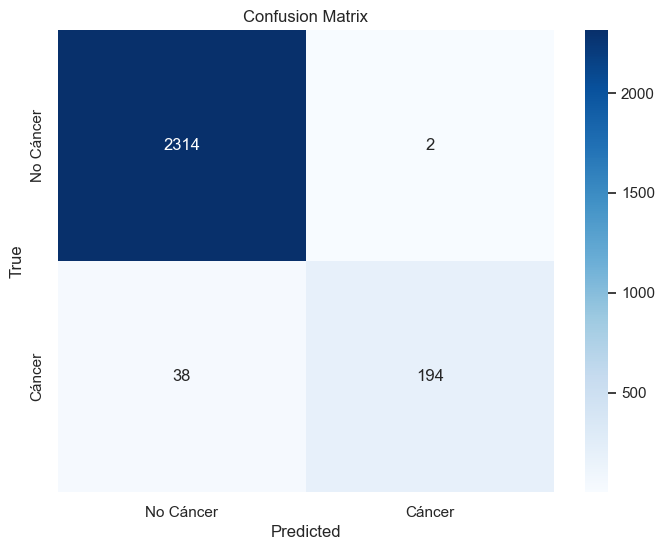

Epoch 1, Training Loss: 0.1227
🔽 Model saved with F1-Score: 0.9837
Validation Loss: 0.0360
F1 Score: 0.9837, Precision: 0.9844, Recall: 0.9843


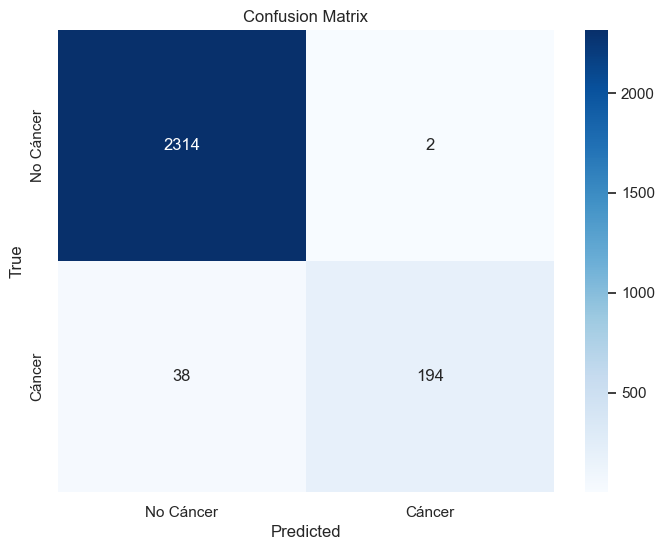

Validation Loss: 0.0336
F1 Score: 0.9806, Precision: 0.9823, Recall: 0.9800


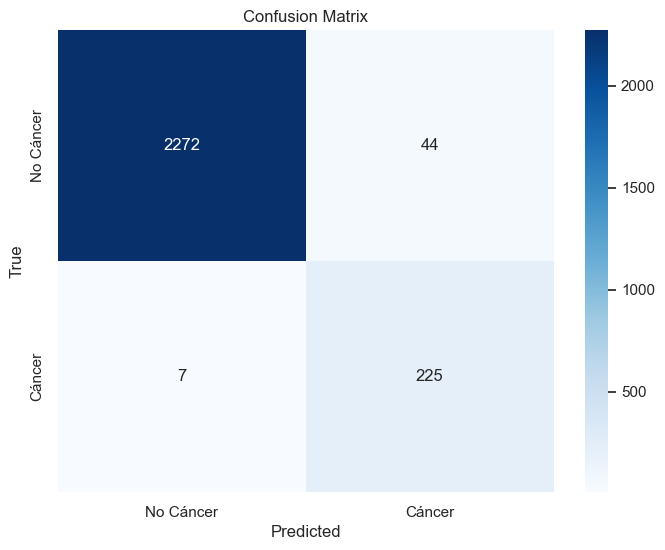

Epoch 2, Training Loss: 0.0422
Validation Loss: 0.0336
F1 Score: 0.9806, Precision: 0.9823, Recall: 0.9800


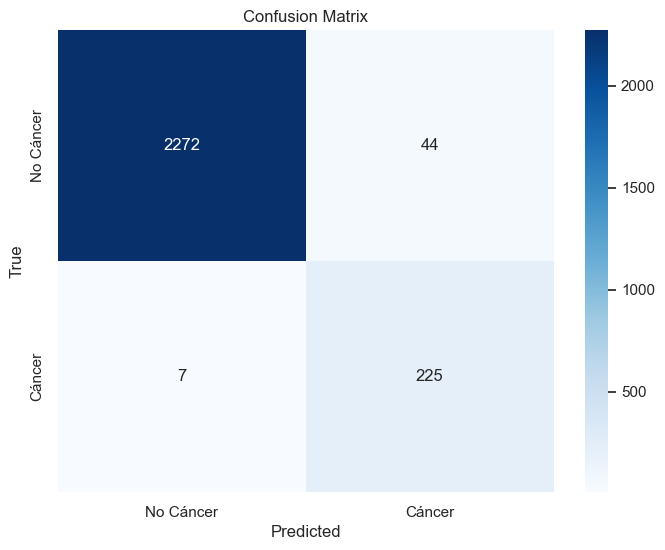

Validation Loss: 0.0364
F1 Score: 0.9782, Precision: 0.9810, Recall: 0.9772


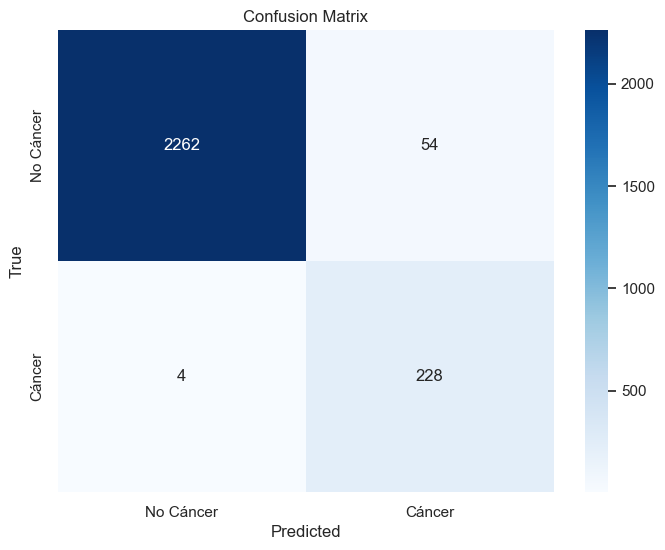

Epoch 3, Training Loss: 0.0398
Validation Loss: 0.0364
F1 Score: 0.9782, Precision: 0.9810, Recall: 0.9772


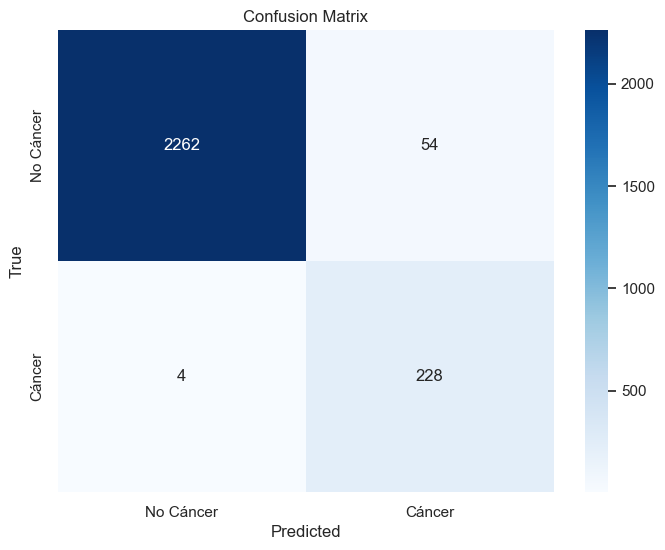

Validation Loss: 0.0395
F1 Score: 0.9828, Precision: 0.9828, Recall: 0.9831


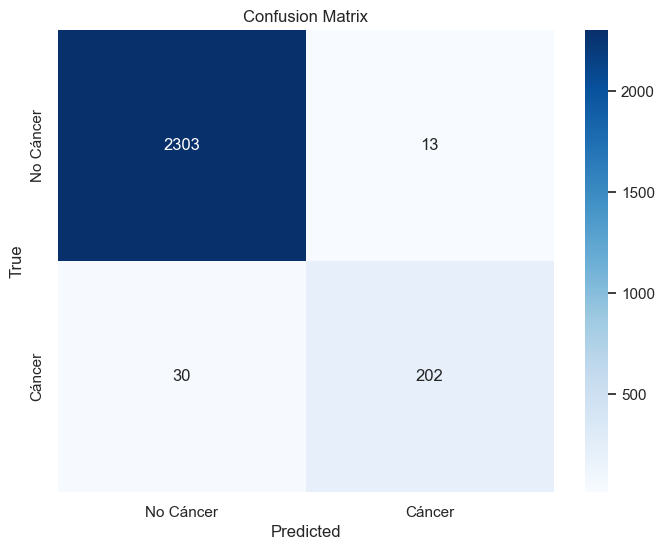

Epoch 4, Training Loss: 0.0399
Validation Loss: 0.0395
F1 Score: 0.9828, Precision: 0.9828, Recall: 0.9831


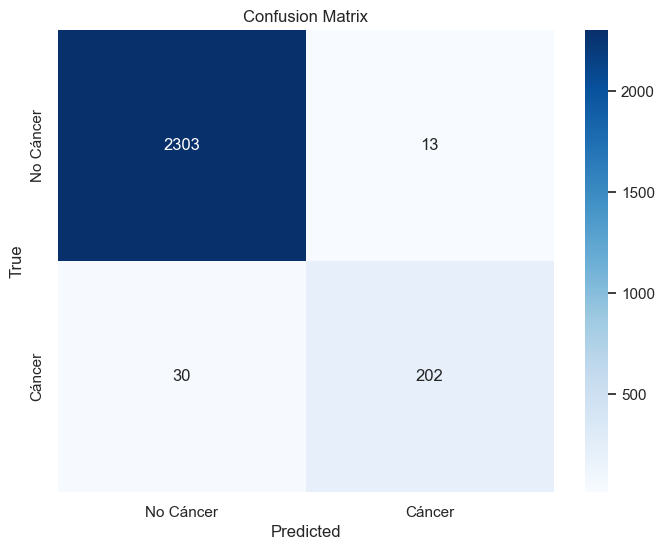

Validation Loss: 0.0297
F1 Score: 0.9846, Precision: 0.9845, Recall: 0.9847


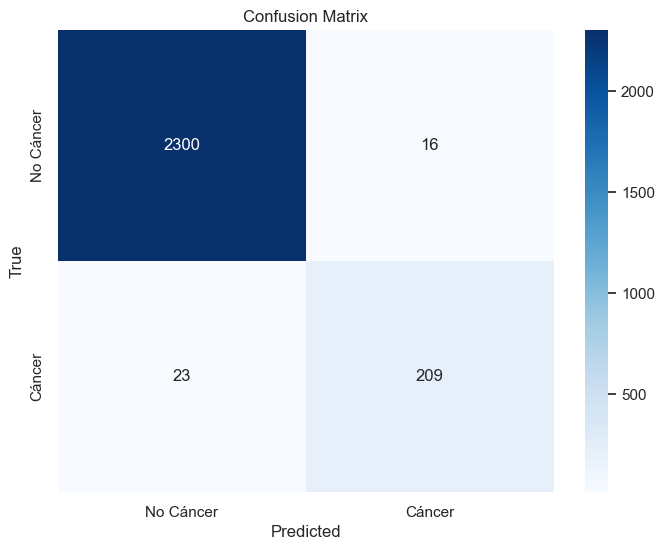

Epoch 5, Training Loss: 0.0369
🔽 Model saved with F1-Score: 0.9846
Validation Loss: 0.0297
F1 Score: 0.9846, Precision: 0.9845, Recall: 0.9847


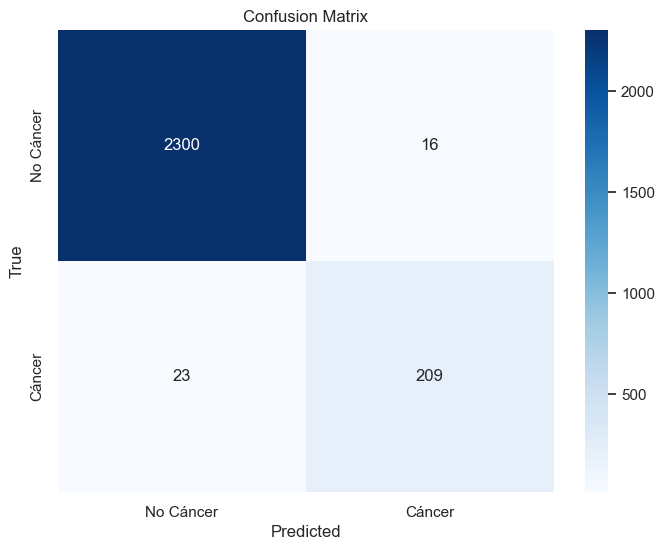

Validation Loss: 0.0294
F1 Score: 0.9843, Precision: 0.9844, Recall: 0.9843


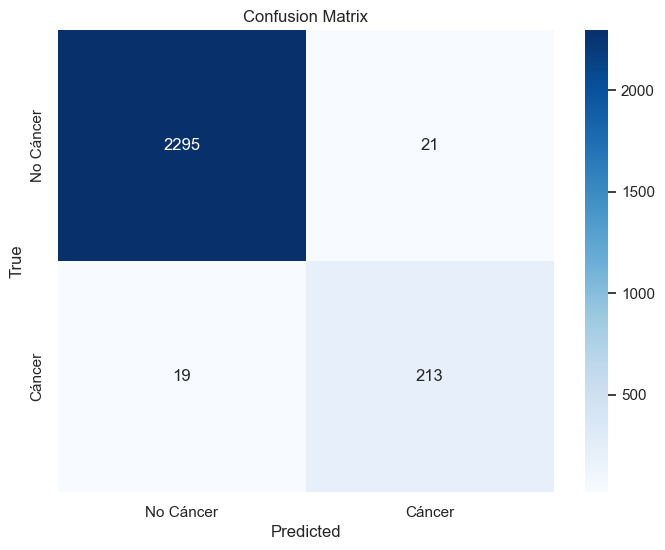

Epoch 6, Training Loss: 0.0361
Validation Loss: 0.0294
F1 Score: 0.9843, Precision: 0.9844, Recall: 0.9843


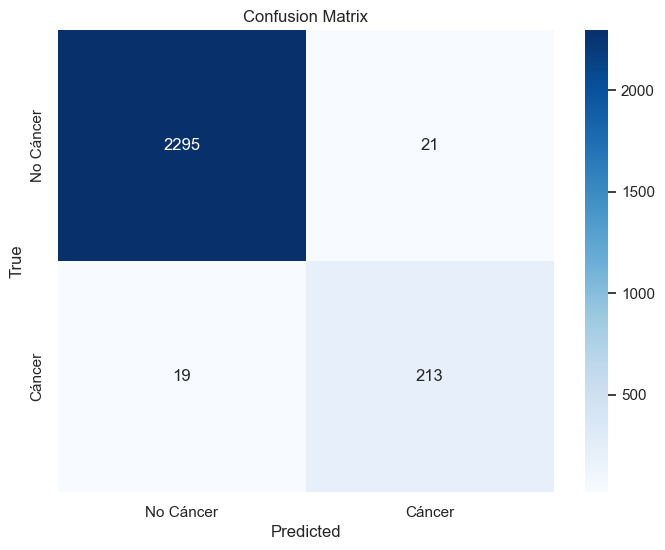

Validation Loss: 0.0301
F1 Score: 0.9840, Precision: 0.9840, Recall: 0.9839


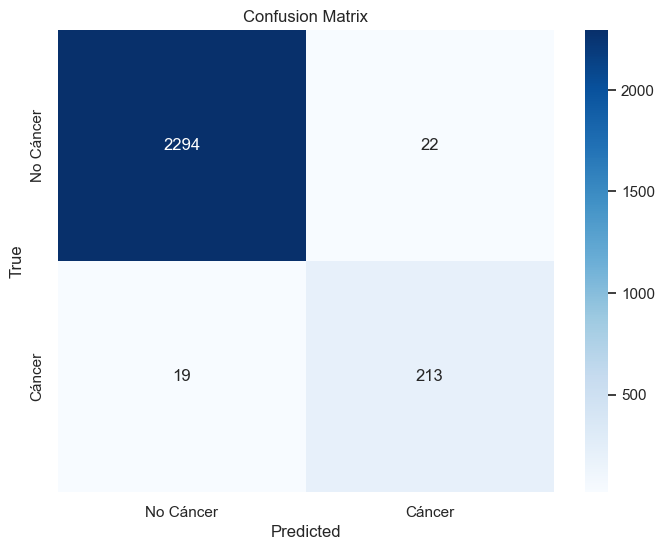

Epoch 7, Training Loss: 0.0363
Validation Loss: 0.0301
F1 Score: 0.9840, Precision: 0.9840, Recall: 0.9839


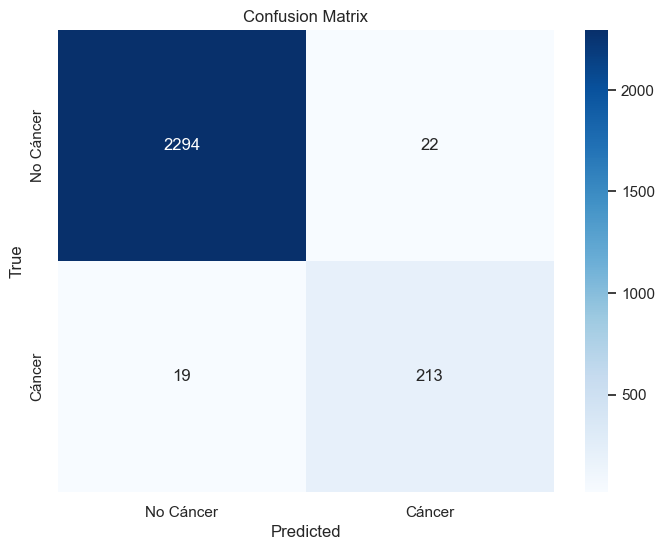

Validation Loss: 0.0299
F1 Score: 0.9825, Precision: 0.9826, Recall: 0.9823


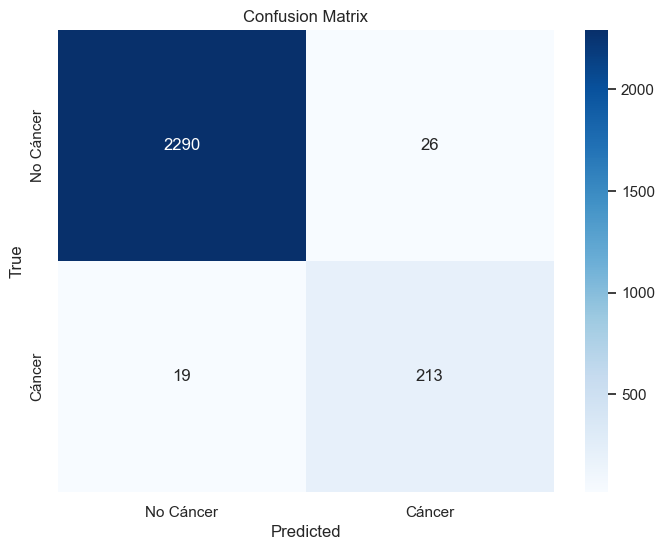

Epoch 8, Training Loss: 0.0361
Validation Loss: 0.0299
F1 Score: 0.9825, Precision: 0.9826, Recall: 0.9823


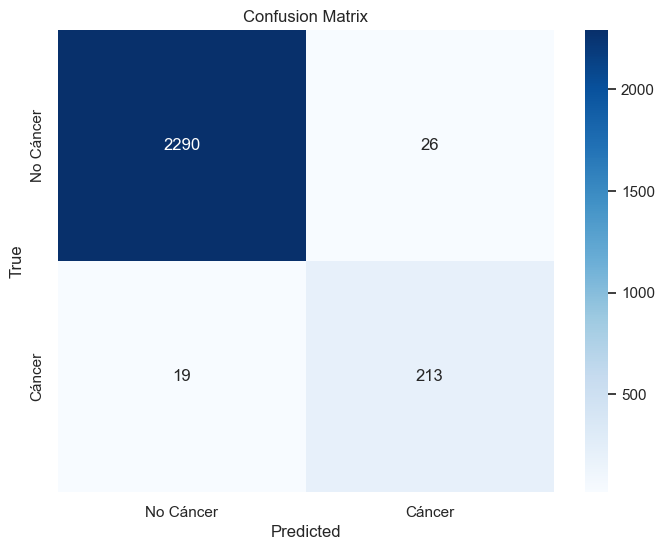

Validation Loss: 0.0302
F1 Score: 0.9849, Precision: 0.9852, Recall: 0.9847


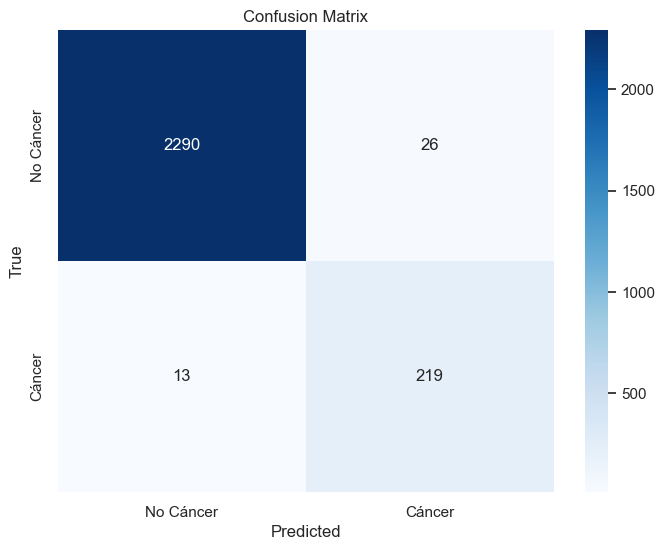

Epoch 9, Training Loss: 0.0354
🔽 Model saved with F1-Score: 0.9849
Validation Loss: 0.0302
F1 Score: 0.9849, Precision: 0.9852, Recall: 0.9847


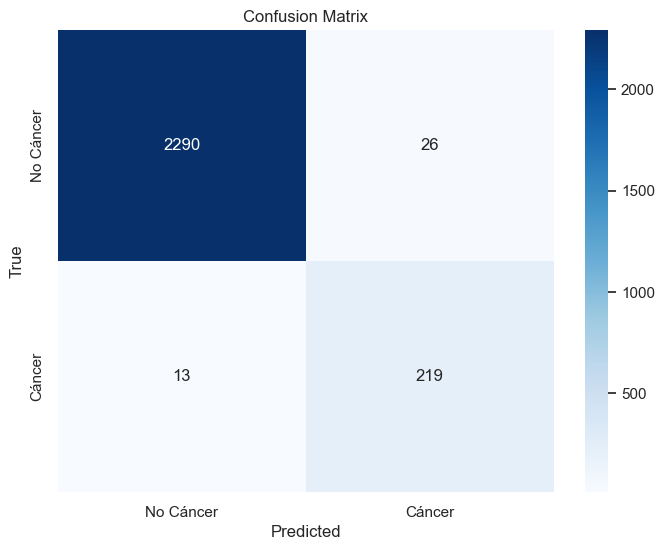

Validation Loss: 0.0325
F1 Score: 0.9796, Precision: 0.9817, Recall: 0.9788


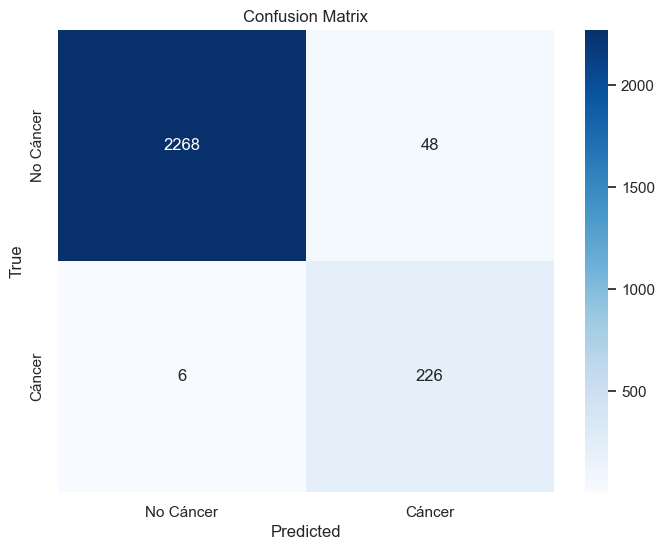

Epoch 10, Training Loss: 0.0358
Validation Loss: 0.0325
F1 Score: 0.9796, Precision: 0.9817, Recall: 0.9788


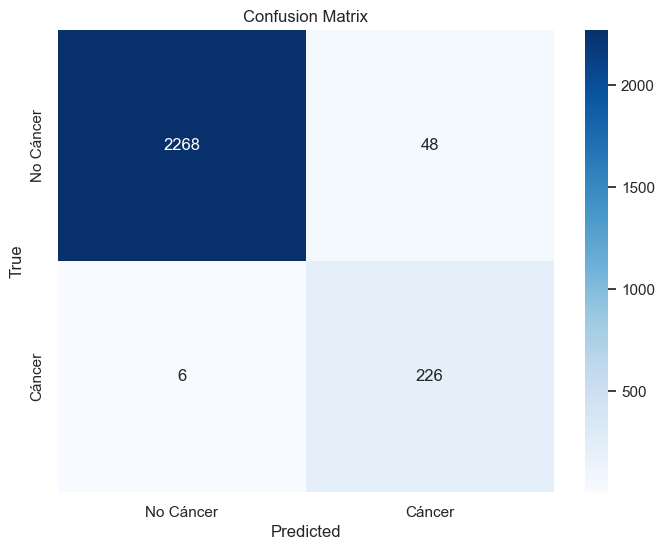

In [142]:
# Inicializar el modelo
num_features = train_features.shape[1] #
model = CombinedModel(num_features=num_features, num_classes=2).to(device)

# Configurar función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Entrenar el modelo
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

In [143]:

def evaluate_model(model, dataloader, criterion):
    model.eval()  # Modo de evaluación
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch_idx, (images, tabular_data, labels) in enumerate(dataloader):
            # Mover datos al dispositivo (GPU o CPU)
            images = images.to(device)
            tabular_data = tabular_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images, tabular_data)
            loss = criterion(outputs, labels)

            # Acumular pérdida
            running_loss += loss.item()

            # Predicciones y etiquetas verdaderas
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular métricas
    average_loss = running_loss / len(dataloader)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    return average_loss, f1

In [144]:
test_loss, test_f1 = evaluate_model(model, val_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

Test Loss: 0.0325, Test F1: 0.9796


In [ ]:
torch.save(model.state_dict(), "../streamlit_app/cancer_classification_model_final.pth")

In [147]:
training_tabular_features = train_df_mlo[['age', 'biopsy', 'invasive', 'BIRADS', 'area_segmentada_px', 'otsu_threshold']]

# Durante el entrenamiento
mean = training_tabular_features.mean(axis=0)  # Media de cada columna
std = training_tabular_features.std(axis=0)    # Desviación estándar de cada columna

print("Medias:", mean)
print("Desviaciones estándar:", std)

Medias: age                      58.897939
biopsy                    0.121492
invasive                  0.063003
BIRADS                    0.744259
area_segmentada_px    94312.531207
otsu_threshold           77.846811
dtype: float64
Desviaciones estándar: age                      10.061221
biopsy                    0.326714
invasive                  0.242980
BIRADS                    0.601103
area_segmentada_px    52269.074577
otsu_threshold           51.539346
dtype: float64
